In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, date, timedelta
import re

from scipy.stats import norm, pearsonr, chi2_contingency, mode
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
set_config(display='diagram')

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, log_loss, roc_auc_score, roc_curve, hamming_loss,precision_score,recall_score,f1_score,auc



import matplotlib.pyplot as plt
import seaborn as sns

# custom helper functions
from confusion import make_confusion_matrix
from to_img import to_img

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 17
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
sns.set(style="ticks", color_codes=True)

%matplotlib inline




from sklearn.preprocessing import StandardScaler, MinMaxScaler


import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
sns.set(style="ticks", color_codes=True)
%matplotlib inline

## 1. Data

The data consists of text scraped from every search result for 'data science/scientist' on Indeed.com using the [Requests](https://docs.python-requests.org/en/master/ "Requests Library"), Tor, and [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/ "BeautifulSoup") libraries.

### 1.1 Load and Inspect Table

In [2]:
# usecols is a memory saver. The entire table is in the low gigabytes, largly because I'm saving the raw HTML each record is derived from.
cols = ['rating', 'company', 'title', 'location', 'extractDate', 'postDate', 'job_type_items', 'requirements', 'description', 'summary', 'salary', 'estimated_salary', 'url']



data = pd.read_csv('../app/data/total.csv', usecols=cols)
print(len(data))
data.info(memory_usage='deep')
data.head(3)

12720
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12720 entries, 0 to 12719
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   company           12720 non-null  object 
 1   description       12720 non-null  object 
 2   estimated_salary  5529 non-null   object 
 3   extractDate       12720 non-null  object 
 4   job_type_items    1964 non-null   object 
 5   location          12720 non-null  object 
 6   postDate          12720 non-null  object 
 7   rating            10612 non-null  float64
 8   requirements      993 non-null    object 
 9   salary            8261 non-null   object 
 10  summary           12720 non-null  object 
 11  title             12720 non-null  object 
 12  url               12720 non-null  object 
dtypes: float64(1), object(12)
memory usage: 116.7 MB


,company,description,estimated_salary,extractDate,job_type_items,location,postDate,rating,requirements,salary,summary,title,url
0,Logic20/20 Inc.,Company Description We’re a six-time “Best C...,NaN,2022-07-27,['Full-time'],"Huntsville, AL",PostedJust posted,3.6,NaN,"From $85,000 a year - Full-time","Along the way, you’ll collaborate daily with a...",Data Scientist,https://www.indeed.com/rc/clk?jk=5d21938b45c3e...
1,WELLS FARGO BANK,About this role: Wells Fargo is seeking a Sen...,NaN,2022-07-27,NaN,"Tempe, AZ",PostedJust posted,3.7,NaN,NaN,They are accountable for execution of all appl...,Lead Enterprise Risk Officer - Strategic Risk ...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...
2,CVS Health,Build data-centric platforms for advanced anal...,NaN,2022-07-27,NaN,Arizona,PostedToday,3.2,NaN,NaN,Build data-centric platforms for advanced anal...,Senior Data Scientist,https://www.indeed.com/rc/clk?jk=433e0eb87a1a6...


The table above is a view of the raw data from the scrape. I'll build the target by reducing the pay column to floating point values; this will require text cleaning which will also be conducted for the rest of the table. Location will be split into new columns for City and State while and because Indeed's search results show dates relative to the date the query was made I'll need to use PostDate and ExtractDate build a DatePosted column. It is important to note that JobUrl and date-related columns will not be converted into features for the logistic regression, instead they will be reattached to the data at the end in order to provide additional information and insights through the EC2 application. The only rows that'l  be using for modelling are JobTitle, Company, Summary, Requirements, and Description.




In [3]:
# check for missing
print(data.isna().sum().sort_values(ascending=False))
data.description.dropna(axis=0, inplace=True)


requirements        11727
job_type_items      10756
estimated_salary     7191
salary               4459
rating               2108
company                 0
description             0
extractDate             0
location                0
postDate                0
summary                 0
title                   0
url                     0
dtype: int64


In [4]:
# check for duplcates.
dupes = data.duplicated()
print(f'Number of dupes: {sum(dupes)}')


#data.drop_duplicates(inplace=True)

# renaming columns
data.columns = map(str.lower, data.columns)
data = data.rename({'title': 'job_title'}, axis=1)

Number of dupes: 9981


The likelihood of seeing duplicates coming from the raw scrapping is very unlikely, but this is still a good check to do in case something changes with Indeed.com's front-end code.

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12720 entries, 0 to 12719
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   company           12720 non-null  object 
 1   description       12720 non-null  object 
 2   estimated_salary  5529 non-null   object 
 3   extractdate       12720 non-null  object 
 4   job_type_items    1964 non-null   object 
 5   location          12720 non-null  object 
 6   postdate          12720 non-null  object 
 7   rating            10612 non-null  float64
 8   requirements      993 non-null    object 
 9   salary            8261 non-null   object 
 10  summary           12720 non-null  object 
 11  job_title         12720 non-null  object 
 12  url               12720 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.3+ MB


Missing values are another story. It seems that Indeed.com doesn't require employers to provide values for every feature, this certainly seems to be the case with requirements, not to mention everywhere salary information coud be held.\
Others, like estimated salary and ratings are generated by Indeed.com but don't exist for every posting.\
job_type_items and salary_and_jType will likely be collapsed into a new column for job types, I'll also do the same with all of the salary related features to build the model's target.

### 1.2 Diagnose Data
In order to proceed with any statistical or exploratory data analysis I will need to wrangle the data quite a bit.
Here, I'll list each of the current feature columns and briefly describe what I'll need to do with them.

Column Groups and Needs
Simple
Salary
Text
etc

In [6]:
# check for missing
print(data.isna().sum().sort_values(ascending=False))

requirements        11727
job_type_items      10756
estimated_salary     7191
salary               4459
rating               2108
company                 0
description             0
extractdate             0
location                0
postdate                0
summary                 0
job_title               0
url                     0
dtype: int64


In [7]:
data.nunique().sort_values(ascending=False)

url                 2608
summary              523
description          450
location             440
job_title            347
company              295
estimated_salary     230
salary                86
rating                25
requirements          18
postdate               6
job_type_items         4
extractdate            2
dtype: int64

# 2. Wrangling & Feature Engineering
Below are the implementations of the data wrangling steps I described above for each feature. Using Numpy, Regex, and Pandas I'll simutaneaously clean the strings, extract and convert numeric information, and create new feature columns.

In [8]:
data.describe(include='all')

,company,description,estimated_salary,extractdate,job_type_items,location,postdate,rating,requirements,salary,summary,job_title,url
count,12720,12720,5529,12720,1964,12720,12720,10612.000000,993,8261,12720,12720,12720
unique,295,450,230,2,4,440,6,NaN,18,86,523,347,2608
top,PAREXEL,Xometry (NASDAQ: XMTR) powers the industrie...,"['', 'Not provided by employer', ""$110K - $139...",2022-07-26,['Full-time'],United States,PostedToday,NaN,US work authorization (Required)Bachelor's (Pr...,Full-time,Proficiency in key statistical and machine lea...,Data Scientist,https://www.indeed.com/rc/clk?jk=c40ea3e3945d1...
freq,536,274,150,10344,1765,306,6607,NaN,266,5634,390,858,130
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.677375,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.446363,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.500000,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.700000,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.000000,NaN,NaN,NaN,NaN,NaN


### Detecting Outliers: Using both the Z-Score and IQR methods
Now that preprocessed the data and building the target variable of Salary let's see conduct a bit more EDA to see if there are any outliers that could potentially skew how the regressor will learn from the training data.

To explore the possibility of outliers I'll start with a box and whisker plot. Those whisters reach 1.5 times past the IQR boundary on either side, and are generally provide a good means of identifying outliers - values beyond the boundaries.

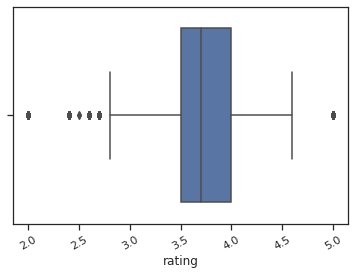

In [9]:
sns.boxplot(data=data, x='rating')
plt.xticks(rotation=30)
plt.show()

To observe the impact this has on the target's shape I'll employ a KDE plot.

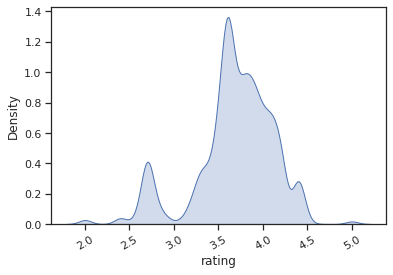

In [10]:
sns.kdeplot(data.rating, shade=True)
plt.xticks(rotation=30)
plt.show()

A plot is helpful in isualizing data, but let's program a few functions to detect and remove outliers based on thresholds.
With the Z-Score, we can determine any data outside 3 standard deviations from the mean of our salary data to be an outlier.
Wheras with the interquartile (IQR) range, the middle 50% of given salaries, I'll set the conventional cutoff of 1.5+/- the IQR as the cutoff.
Values found outside of either range will be collected into a list and that'll allow for some fancy indexing so those particular postings can be examined and removed programatically.

##### 1.2a Rating

As the only feature coming in with numeric (float) values I should just need to scale it. I'll address missing values by imputing zero. The rationale behind this is that an unrated company should simply be rated as zero.
print(sorted(data.rating.unique()))

'rating'\
Roughly a third of the data is missing values for the company rating feature. At first I used np.fillna(0) to imput 0 for all the missing values but that sharply right-skewed the distribution towards zero.\
Then I checked is scaling the data would fix the bi-modality but I think I have two options here, drop all those records or drop a potentially valuable feature.\
For now, I'll drop the records, I can always get more, and in the future I could conduct linear regression to imput the values.

In [11]:
def featureReport(data,feature):
    """Returns summary information for a given feature.

    Args:
        data (DataFrame): data collection
        feature (DataFrame): particular feature identifier
    """
    data_len = len(data)
    missing_len = len(data[data[feature].isna()])
    print(f'-- {feature} report --')
    if missing_len > 0:
        print(f'Missing {missing_len} out of {data_len} Records')
        print(f'Percent Missing: {round((missing_len/data_len)*100,1)}%')
    else:
        print('Nothing Missing')
        print(f'Records: {data_len}')
    
    print(f'Unique Values: {len(data[feature].unique())}')

    notna = data[feature].notna()

    if (data[feature].dtype != (object)) and feature !='dateposted':

        mini = np.min(data[notna][feature])
        if mini != None:
            print(f'Min: {round(mini,4)}')

        maxi = np.max(data[notna][feature])
        if maxi != None:
            print(f'Max: {round(maxi,4)}')

        mean = np.mean(data[notna][feature])
        if mean != None:
            print(f'Mean: {round(mean,4)}')

        mode_ = mode(data[notna][feature])[0][0]
        if mode_ != None:
            print(f'Mode: {round(mode_,4)}')

        std = np.std(data[notna][feature])
        if std != None:
            print(f'Std.Dev: {round(std,4)}')
        #Percentage=(missing_len/len_data)*100


featureReport(data, feature = 'rating')

-- rating report --
Missing 2108 out of 12720 Records
Percent Missing: 16.6%
Unique Values: 26
Min: 2.0
Max: 5.0
Mean: 3.6774
Mode: 3.6
Std.Dev: 0.4463


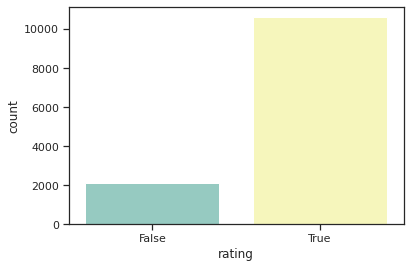

83.43% of the data have rating values


In [12]:
sns.countplot(x='rating', data=data.notnull(), palette='Set3')
plt.show()

null = len(data[data.rating.isnull()])
nnull = len(data[data.rating.notnull()])
print(f'{round(nnull/len(data)*100,2)}% of the data have rating values')

For now I'll drop these. I'm considering what and how to impute. What I'd like to do is run clustering on the data, or perhaps logistic regression. One thing I know is that the picture will become clearer as I gain more data. For now though, the amount of missing values is very small.

In [13]:

data.dropna(subset=['rating'], inplace=True)
print(len(data))

10612


outliers



With the Z-Score, we can determine any data outside 3 standard deviations from the mean of our salary data to be an outlier.
Wheras with the interquartile (IQR) range, the middle 50% of given salaries, I'll set the conventional cutoff of 1.5+/- the IQR as the cutoff.
Values found outside of either range will be collected into a list and that'll allow for some fancy indexing so those particular postings can be examined and removed programatically.

#### Z-Score
Salaries 3 standard deviations away from the mean will be listed as outliers.
Here we can see that there are five records with salary values outside the Z-score threshold.

To explore the possibility of outliers I'll start with a box and whisker plot. Those whisters reach 1.5 times past the IQR boundary on either side, and are generally provide a good means of identifying outliers - values beyond the boundaries.


A plot is helpful in isualizing data, but let's program a few functions to detect and remove outliers based on thresholds.
With the Z-Score, we can determine any data outside 3 standard deviations from the mean of our salary data to be an outlier.
Wheras with the interquartile (IQR) range, the middle 50% of given salaries, I'll set the conventional cutoff of 1.5+/- the IQR as the cutoff.
Values found outside of either range will be collected into a list and that'll allow for some fancy indexing so those particular postings can be examined and removed programatically.

In [14]:
outliers = []
def z_detect(data, feature):
    sample = data[feature]
    threshold=3
    mean = np.mean(sample)
    std = np.std(sample)
    
    for i in sample:
        z_score = (i-mean)/std
        if np.abs(z_score) > threshold:
            outliers.append(i)
    if len(outliers) == 0:
        pass
    else:
        return sorted(outliers)
        
z = z_detect(data, feature = 'rating')
data.loc[data['rating'].isin(z)][:].rating.value_counts()

2.0    48
Name: rating, dtype: int64

In [15]:
data.loc[data['rating'].isin(z)].head(3)

,company,description,estimated_salary,extractdate,job_type_items,location,postdate,rating,requirements,salary,summary,job_title,url
7026,Virginia Housing,We’re looking for amazing people! Come join Vi...,NaN,2022-07-26,['Full-time'],"Hybrid remote in Richmond, VA 23220",PostedToday,2.0,NaN,"$86,297 - $112,186 a year - Full-time","Identify business challenges, opportunities re...",Sr. Business Data Analyst (Hybrid),https://www.indeed.com/company/Virginia-Housin...
7039,Virginia Housing,We’re looking for amazing people! Come join Vi...,NaN,2022-07-26,['Full-time'],"Hybrid remote in Richmond, VA 23220",PostedToday,2.0,NaN,"$86,297 - $112,186 a year - Full-time","Identify business challenges, opportunities re...",Sr. Business Data Analyst (Hybrid),https://www.indeed.com/company/Virginia-Housin...
7053,Virginia Housing,We’re looking for amazing people! Come join Vi...,NaN,2022-07-26,['Full-time'],"Hybrid remote in Richmond, VA 23220",PostedToday,2.0,NaN,"$86,297 - $112,186 a year - Full-time","Identify business challenges, opportunities re...",Sr. Business Data Analyst (Hybrid),https://www.indeed.com/company/Virginia-Housin...


#### IQR
Salaries outside 1.5 times the interquartile range boundaries, either above or below will be listed as outliers.\
Here, I clearly demarcate the quartiles as well as the uppet and lower boundaries. Before removing these outliers let's take a look.

There aren't any outliers beyond the lower bound for either test so let's take a look at what's above the IQR threshold.\
While not guarenteed, its a good thing that both tests seem to identify the same five records, the salary values match.

In [16]:
def iqr_detect(data, feature):
    """takes data, selects particular feature, analyses outliers using IQR method, then trims out data that contains detected outliers

    Args:
        data (Dataframe): data
        feature (string): identifier for particular feature

    Returns:
        sns plots and a DataFrame: pre and post outlier trimming plots
    """
    
    # plotting
    def plotting(axlabel_):
        """provides pre and post outlier trimming plots

        Args:
            axlabel_ (string): permits ax label to be passed as an arguement at each function call
        """

        # histogram
        sns.histplot(data[feature])
        plt.show()

        # volin plot
        sns.violinplot(x=data[feature], data=data)
        plt.xticks(rotation=30)
        plt.show()

        # distribution plot
        sns.distplot(data[feature], fit=norm, kde=True, kde_kws={'color': 'k', 'label': 'KDE', }, axlabel=axlabel_)
        

        plt.axvline(x=q1, label='Q1', c = 'y')
        plt.axvline(x=q2, label='Q2', c = 'g')
        plt.axvline(x=q3, label='Q3', c = 'b')

        plt.axvline(x=iqr_lower, label = 'IQR Lower', c = 'black')
        plt.axvline(x=iqr_upper, label = 'IQR Upper', c = 'black')
        plt.axvline(x=np.mean(data[feature]), label='mean', c = 'r')

        plt.xticks(rotation=30)
        plt.title(f'{feature.capitalize()}')
        plt.legend()
        plt.show()
        

        # boxplot
        sns.boxplot(data=data, x=feature)
        plt.xticks(rotation=30)
        plt.title(f'{feature.capitalize()}')
        plt.show()


    if feature == 'rating':
        if feature == 'rating':
            data = data[data[feature].notna()]
        q1 = np.quantile(data[feature], 0.25)
        q2 = np.quantile(data[feature], 0.5)
        q3 = np.quantile(data[feature], 0.75)

        # calc iqr
        iqr = (q3 - q1)
        # expand iqr to discern outliers
        iqr_x = iqr*1.5
        # setting the lower and upper limits

        iqr_lower = q1-iqr_x
        iqr_upper = q3+iqr_x
        plotting(axlabel_='With Outliers (if any)')
        # report
        print(f'There are {len(data[data[feature] > iqr_upper])} records below and {len(data[data[feature] < iqr_lower])} above.')
        # trimming outliers
        '''
        lower_outs = data[data[feature] < iqr_lower]
        upper_outs = data[data[feature] > iqr_upper]
        '''
        print(f'Records Including Outliers: {len(data)}')

        data = data[data[feature] >= iqr_lower]
        data = data[data[feature] <= iqr_upper]

        print(f'Records Without Outliers: {len(data)}')

        plotting(axlabel_='Outliers Removed')


    elif feature == 'salaries':
        q1 = np.quantile(data[data[feature].notna()][feature], 0.25)
        q2 = np.quantile(data[data[feature].notna()][feature], 0.5)
        q3 = np.quantile(data[data[feature].notna()][feature], 0.75)

                # calc iqr
        iqr = (q3 - q1)
        # expand iqr to discern outliers
        iqr_x = iqr*1.5
        # setting the lower and upper limits

        iqr_lower = q1-iqr_x
        iqr_upper = q3+iqr_x

        plotting(axlabel_='With Outliers (if any)')
        # report
        print(f'There are {len(data[data[feature] > iqr_upper])} records below and {len(data[data[feature] < iqr_lower])} above.')
        # trimming outliers
        '''
        lower_outs = data[data[feature] < iqr_lower]
        upper_outs = data[data[feature] > iqr_upper]
        '''
        print(f'Records Including Outliers: {len(data)}')

        data = data[data[feature] >= iqr_lower]
        data = data[data[feature] <= iqr_upper]

        print(f'Records Without Outliers: {len(data)}')

        plotting(axlabel_='Outliers Removed')




    
    
    return data, q1, q3




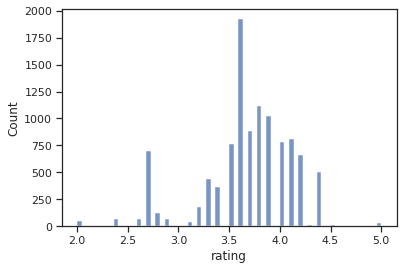

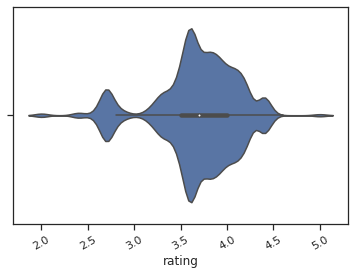

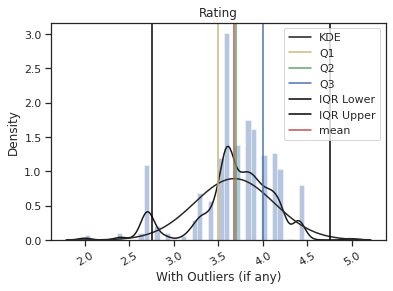

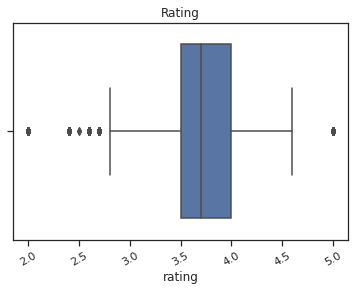

There are 31 records below and 878 above.
Records Including Outliers: 10612
Records Without Outliers: 9703


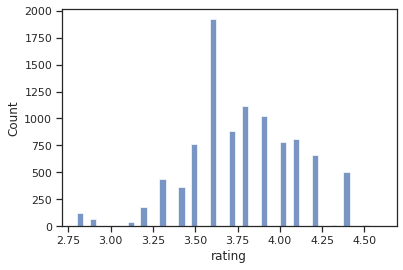

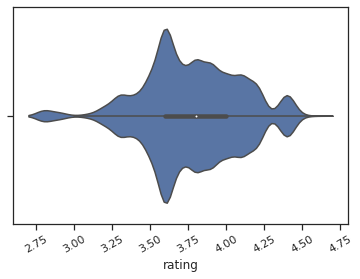

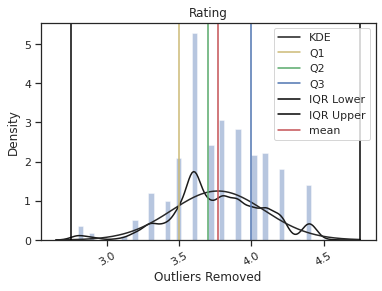

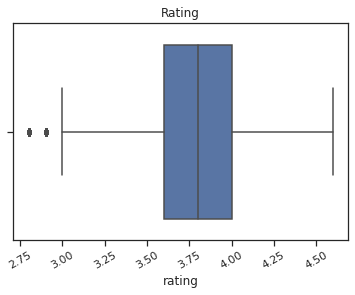

-- rating report --
Nothing Missing
Records: 9703
Unique Values: 19
Min: 2.8
Max: 4.6
Mean: 3.7679
Mode: 3.6
Std.Dev: 0.3197


In [17]:
data, q1, q3 = iqr_detect(data, feature='rating')
featureReport(data, feature = 'rating')

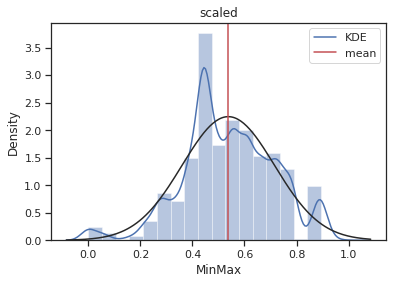

-- rating report --
Nothing Missing
Records: 9703
Unique Values: 19
Min: 0.0
Max: 1.0
Mean: 0.5377
Mode: 0.4444
Std.Dev: 0.1776


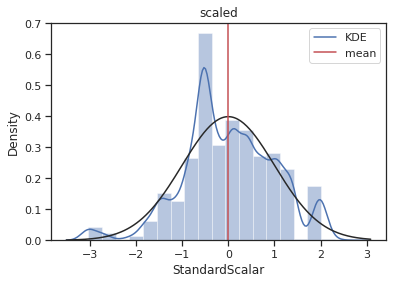

-- rating report --
Nothing Missing
Records: 9703
Unique Values: 19
Min: -3.0273
Max: 2.6027
Mean: 0.0
Mode: -0.5251
Std.Dev: 1.0


In [18]:
# The below is a preview of how this feature will be shaped with a given slaing method to be used in the preprocessing piepline
scalar = MinMaxScaler()
minmax_scaled_ratings = pd.DataFrame(scalar.fit_transform(pd.DataFrame(data.rating)), columns=['rating'])
sns.distplot(minmax_scaled_ratings, fit=norm, bins=minmax_scaled_ratings.rating.nunique(), kde=True, kde_kws={'color': 'b', 'label': 'KDE'}, axlabel='MinMax')
plt.title('scaled')
#ax.set_xticks(data.rating.unique())
plt.axvline(x=np.mean(minmax_scaled_ratings.rating), label='mean', c = 'r')
plt.legend()
plt.show()
featureReport(minmax_scaled_ratings, feature = 'rating')



scalar = StandardScaler()
standard_scaled_ratings = pd.DataFrame(scalar.fit_transform(pd.DataFrame(data.rating)), columns=['rating'])
sns.distplot(standard_scaled_ratings, fit=norm, bins=minmax_scaled_ratings.rating.nunique(), kde=True, kde_kws={'color': 'b', 'label': 'KDE'}, axlabel='StandardScalar')
plt.title('scaled')
#ax.set_xticks(data.rating.unique())
plt.axvline(x=np.mean(standard_scaled_ratings.rating), label='mean', c = 'r')
plt.legend()
plt.show()
featureReport(standard_scaled_ratings, feature = 'rating')


I'm going to run a few tests to see which scaling is best. I suspect it will fall on standard deviation, which for MinMax is tighter. Other than that I'm pleased with how this feature has been preprocessed.<br>\
For further analysis I'd like to analyze the trends in who's hiring:
- the trends of each of my four target-associated sub-populations.
- which companies are going big.
- historical, weekly, monly, annually even - this could be a backdoor into stock market and company valuation analysis.

In [19]:
# Companies that share the mode as their rating
data[data.rating == mode(data.rating)[0][0]].company.value_counts()[:5]

PAREXEL               536
CyberCoders           350
UnitedHealth Group    288
Target                199
Uber                   83
Name: company, dtype: int64

##### 1. Job Type


'job_type_items'\
    I'm going to treat these as likert values, converrting each of these string formatted lists into an ordinal values for a new column.



In [20]:
data['job_type_items'] = data['job_type_items'].fillna('None')
data.job_type_items.unique()

array(["['Full-time']", 'None', "['Part-time']"], dtype=object)

In [21]:

def jobtype(data):
    """Used for creating a new feature containing nominal values for the job type.

    Args:
        data (string): Values from the 'job_type_items' column.

    Returns:
        string: Extracted and simplified values for each category.
    """
    out = ''
    if type(data) == str:
        if re.search('full', data):
            out = 'full'
        if re.search('part', data):
            out = 'part'
        if re.search('contract', data):
            out = 'contract'
        if re.search('temp', data):
            out = 'temp'
        return out
    else:
        pass

cols = ['company','description', 'job_type_items','location','postdate','requirements',	'summary','job_title']
for txt_col in cols:
    data[txt_col] = data[txt_col].str.lower()



data['jobtype'] = data.job_type_items.apply(jobtype)

##### 1.2a Dates

'extractdate' & 'postdate'\
extract_date is a string showing the day the record was webscrapped.
post_date is a string description of the relative age of each post from the date it was posted to the day it was webscrapped.
Converting post_date to a number will give me the the posts ae, which I'll then subtract from it's extract date in order to build a new feature carrying values for the DATE each job posting has been submitted to Indeed.com.

The extractdate is the value given by my parser representing the date the data was pulled from Indeed.com.\
The postdate is how many days have passed since the post was made and when the search was conducted (by my webscraper).\
The task is to find the delta (difference), the intervening days since the post was made, and subtract it from the extract date so I can get the actual date publishd.

This isn't going into the pipelie, despite some interesting patterns, I don't think there's enough periodic/seasonality information available here. Still, great for visualizing the job market.



-- extractdate report --
Nothing Missing
Records: 9703
Unique Values: 2

-- postdate report --
Nothing Missing
Records: 9703
Unique Values: 5



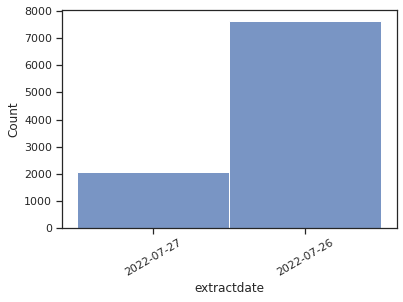

,extractdate,postdate
0,2022-07-27,postedjust posted
1,2022-07-27,postedjust posted
2,2022-07-27,postedtoday
3,2022-07-27,postedtoday
4,2022-07-27,postedtoday


In [22]:
features = data[['extractdate', 'postdate']].columns

for feature_ in features:
    featureReport(data, feature = feature_)
    print('')

#plt.title('extractdate ')
sns.histplot(data['extractdate'])
plt.xticks(rotation=30)
plt.show()


data[['extractdate', 'postdate']].head()

In [23]:
delta = timedelta(1)
delta

datetime.timedelta(days=1)

In [24]:
def postD(row):
    """Critical function that converts postdate values into relative (in days) distance from the extract date.
    Args:
        data (string): text descrption of how old the post is.
    Returns:
        npnan or int: numeric representation of post age
    """
    delta = timedelta(0)
    if row['postdate'] != np.nan:

        if row['postdate'] in ['postedtoday', 'postedjust posted', 'hiring ongoing']:
            delta = timedelta(0)
        elif row['postdate'] in ['PostedPosted 1 day ago', 'Posted1 day ago', 'postedposted 1 day ago']:
            delta = timedelta(1)
        elif row['postdate'] in ['PostedPosted 2 days ago', 'Posted2 day ago']:
            delta = timedelta(2)
        elif row['postdate'] in ['PostedPosted 3 days ago', 'Posted3 day ago']:
            delta = timedelta(3)
        value = pd.to_datetime(row['extractdate'])-delta
    return value



data['dateposted'] = data.apply( lambda row : postD(row), axis = 1)
print(featureReport(data, feature = 'extractdate'),'\n')
print(featureReport(data, feature = 'postdate'),'\n')
print(featureReport(data, feature = 'dateposted'),'\n')
data[['extractdate', 'postdate','dateposted']].head()

-- extractdate report --
Nothing Missing
Records: 9703
Unique Values: 2
None 

-- postdate report --
Nothing Missing
Records: 9703
Unique Values: 5
None 

-- dateposted report --
Nothing Missing
Records: 9703
Unique Values: 3
None 



,extractdate,postdate,dateposted
0,2022-07-27,postedjust posted,2022-07-27
1,2022-07-27,postedjust posted,2022-07-27
2,2022-07-27,postedtoday,2022-07-27
3,2022-07-27,postedtoday,2022-07-27
4,2022-07-27,postedtoday,2022-07-27


Even though it's not being used directly in my analysis, for now - I would like to find play with time series and seasonality. There's a pairplot in the multivariate analysis section that illustrates what I'm detecting in the data, a hump in the midweek.

#### Company & Job Title

'company'\
There's presently 96 different companies - that's a ton of dimensions added to the data, and I've still got to add count vectorizer. I'll try label encoding these. In the future, shifting these into clusters might be useful.\
Other than that, this variable doesn't seem to need much - 

data.company.value_counts()


'job_title'\
Although the webscrapper searches for 'data scientist' the results contain over 80 unique job titles. This is largely due to a prefix or suffix that provides the role's specialization at that particular company for that particular job posting. These include items like 'Marketing', 'Senior', 'Geospatial...'.
I'll start by cleaning and simplifying these values, i.e. appearences of 'Sr' can be converted to 'Senior'. This will significantly reduce the number of unique values, hopefully increasing model accuracy.


'job_title'\
Oddly enough, these number as many as company, I suspect multicolinearity. I'll come back to collapse these a bit and perhaps build a new feature for specializations out of these.
To be label encoded and possibly clustered later.

In [25]:
print(data.company.unique()[:20])

['logic20/20 inc.' 'wells fargo bank' 'cvs health'
 'amazon web services, inc.' 'adelante healthcare' 'usaa'
 'unitedhealth group' 'cybercoders' 'bosch group'
 'university of california san francisco' 'imdb.com, inc.' 'plaid'
 'amazon.com services llc' 'boeing' 'sony playstation network' 'uber'
 'square' 'visa' 'pg&e corporation' 'apple']


In [26]:

str_features = data[['company','job_title']]
for feature in str_features.columns:
    print(featureReport(data, feature = feature),'\n')
    
data[['company','job_title']].head()

-- company report --
Nothing Missing
Records: 9703
Unique Values: 221
None 

-- job_title report --
Nothing Missing
Records: 9703
Unique Values: 282
None 



,company,job_title
0,logic20/20 inc.,data scientist
1,wells fargo bank,lead enterprise risk officer - strategic risk ...
2,cvs health,senior data scientist
3,"amazon web services, inc.",machine learning engineer
4,adelante healthcare,senior financial data analyst


Requirements do exist, but values are extremeley sparse. I'm keen to run NLP on this feature alone, encoding new features that are more or less associated with the target.


In [27]:
def cleanText_comp_jtitle(sentence):
    """clean the string of any punctuation or special characters

    Args:
        sentence (string): dirty string

    Returns:
        string: clean string
    """
    #function to 
    cleaned = sentence.replace('AI/ML','artificial intelligence machine learning')
    cleaned = cleaned.replace('AI','artificial intelligence')
    cleaned = cleaned.replace('ML','machine learning')
    cleaned = cleaned.replace('Sr.','senior')
    cleaned = cleaned.lower()
    cleaned = re.sub(r'[^a-zA-Z0-9 \n\.|.]+', r'', cleaned)
    cleaned = cleaned.replace('  ',' ')
    return cleaned

str_features = data[['company','job_title']]
for i in str_features.columns:
    data[i] = data[i].apply(cleanText_comp_jtitle)


for i in str_features.columns:
    print(featureReport(data, feature = i),'\n')
str_features.head(5)

-- company report --
Nothing Missing
Records: 9703
Unique Values: 221
None 

-- job_title report --
Nothing Missing
Records: 9703
Unique Values: 281
None 



,company,job_title
0,logic20/20 inc.,data scientist
1,wells fargo bank,lead enterprise risk officer - strategic risk ...
2,cvs health,senior data scientist
3,"amazon web services, inc.",machine learning engineer
4,adelante healthcare,senior financial data analyst


In [28]:
print('All Time Top Employers' + "\n\n" + f'{data.company.value_counts()[:10]}')
print('Most Frequently Observed Job Titles' + "\n\n" + f'{data.job_title.value_counts()[:10]}')

All Time Top Employers

parexel                         536
amazon.com services llc         471
cybercoders                     350
fidelity investments            350
unitedhealth group              288
twiceasnice recruiting          268
the travelers companies inc.    207
johnson johnson                 202
target                          199
optum labs                      177
Name: company, dtype: int64
Most Frequently Observed Job Titles

data scientist                                                  641
senior data scientist                                           441
senior data analyst                                             379
remote data scientist predictive maintenance exp. req. ...      268
lead data scientist digital product development                 202
senior manager statistical programming                          200
machine learning leader virtual hiring event                    177
principal statistical programmer                                136
remote 

#### Location


'location'\
This feature holds a wealth of information: state, city/remote, and in some cases a zip code.
Zip codes seem to be a recent addition to the information I can get from Indeed.com but since its presence is rather sparse I'll just extract city/remote and state values, splitting them into their respective columns.

data.job_type_items.unique()

In [29]:
def cleanText_loc(row):
    """extracts, splits, and reassigns vaues from the location value in each row of data

    Args:
        row (string): row in the DataFrame

    Returns:
        DataFrame: row with location information assigned to new features, state, city, and remote status
    """
    #function to clean the word of any punctuation or special characters
    states = [', AK', 'Alaska', ', AL', 'Alabama', ', AR', 'Arkansas', ', AZ', 'Arizona', ', CA', 'California', ', CO', 'Colorado', ', CT', 'Connecticut', ', DC', 'District of Columbia', ', DE', 'Delaware', ', FL', 'Florida', ', GA', 'Georgia', ', HI', 'Hawaii', ', IA', 'Iowa', ', ID', 'Idaho', ', IL', 'Illinois', ', IN', 'Indiana', ', KS', 'Kansas',
 ', KY', 'Kentucky', ', LA', 'Louisiana', ', MA', 'Massachusetts', ', MD', 'Maryland', ', ME', 'Maine', ', MI', 'Michigan', ', MN', 'Minnesota', ', MO', 'Missouri', ', MS', 'Mississippi', ', MT', 'Montana', ', NC', 'North Carolina', ', ND', 'North Dakota', ', NE', 'Nebraska', ', NH', 'New Hampshire', ', NJ', 'New Jersey', ', NM', 'New Mexico',
 ', NV', 'Nevada', ', NY', 'New York', ', OH', 'Ohio', ', OK', 'Oklahoma', ', OR', 'Oregon', ', PA', 'Pennsylvania', ', RI', 'Rhode Island', ', SC', 'South Carolina', ', SD',
 'South Dakota', ', TN', 'Tennessee', ', TX', 'Texas', ', UT', 'Utah', ', VA', 'Virginia', ', VT', 'Vermont', ', WA', 'Washington', ', WI', 'Wisconsin', ', WV', 'West Virginia',
 ', WY', 'Wyoming']

    for i in states:
        if i in row['location']:
            row['state'] = i.strip(',')
        if ',' in row['location']:
            row['city'] = row['location'].split(',')[0].replace('Remote in ','')
            #row['city'] = row['city'].replace('Hybrid','')
            row['city'] = row['city'].replace('remote in ','').strip()
    



    if 'Hybrid remote' in row['location']:
        row['remote'] = 'Hybrid'

    elif 'remote in ' in row['location']:
        row['remote'] = 'Remote in'
    elif ('Remote' or 'remote') in row['location']:
        row['remote'] = 'Remote'
    else:
        row['remote'] = 'Not Remote'

    return row

data = data.copy()
data['remote'] = ''
data['state'] = ''
data['city'] = ''
data = data.apply( lambda row : cleanText_loc(row), axis = 1)


str_features = ['location','state','city','remote']

for i in str_features:
    print(featureReport(data, feature = i),'\n')


data[str_features].head(5)


-- location report --
Nothing Missing
Records: 9703
Unique Values: 369
None 

-- state report --
Nothing Missing
Records: 9703
Unique Values: 1
None 

-- city report --
Nothing Missing
Records: 9703
Unique Values: 192
None 

-- remote report --
Nothing Missing
Records: 9703
Unique Values: 2
None 



,location,state,city,remote
0,"huntsville, al",,huntsville,Not Remote
1,"tempe, az",,tempe,Not Remote
2,arizona,,,Not Remote
3,arizona,,,Not Remote
4,"phoenix, az 85012 (encanto area)",,phoenix,Not Remote


#### descriptive text


'requirements'\
I will most likely merge this in with the description prior to conducting NLP. The rationale is that these explicit requirements may be echoed in the description or summary, so by adding them to the corpus I'll raise the scores derived from their increaseed frequency. Eventually I wiuld like to build a set of requirements that I can use in with a clustering algorithm, like KNN, to find/define subgroups within the sample population.


'summary'\
Much like the description, these are unique. COming from the search results page itself, these are brief descriptions of each job. In most cases this is not merely an abridgement of the summary. Like 'requirement' I'll start by lumping these texts in with description so analysis of the corpus can be boosted by the added descriptions.

for i in data.summary[:3]:
    print(i)


'description'\
Each value is a unique string of the full job description. I'll lower and remove special characters but this feature will be dealt with seperately in its own NLP process.


'url'\
Like raw_doc_soup, I'm simply keeping these in case I need to go back and re-parse the raw data. In fact, this URL points directly to the page where that raw doc soup is found.
I may also be able to detect job post updates and duplicates by using these unique addresses.


data.raw_desc_soup[1][:1000]
data.url[0]


In [30]:
str_features = data[['description','summary','requirements']]
for i in str_features.columns:
    print(featureReport(data, feature = i),'\n')
str_features.head(5)

-- description report --
Nothing Missing
Records: 9703
Unique Values: 357
None 

-- summary report --
Nothing Missing
Records: 9703
Unique Values: 416
None 

-- requirements report --
Missing 9100 out of 9703 Records
Percent Missing: 93.8%
Unique Values: 8
None 



,description,summary,requirements
0,company description we’re a six-time “best c...,"along the way, you’ll collaborate daily with a...",NaN
1,about this role: wells fargo is seeking a sen...,they are accountable for execution of all appl...,NaN
2,build data-centric platforms for advanced anal...,build data-centric platforms for advanced anal...,NaN
3,"bachelors degree in computer science, engineer...","bachelors degree in computer science, engineer...",NaN
4,senior financial data analyst3033 n central av...,"ability to research, analyze, and present fina...",NaN


In [31]:
len(data)
data.dropna(subset=['description'], inplace=True)
len(data)

9703

In [32]:

def cleanText_descriptive(row):

    summary = row['summary']
    description = row['description']
    requirements = row['requirements']

    text = summary+' '+description
    if type(requirements) != type(np.nan):
        text = requirements+' '+text
    
    sentences = text.split('.')
    clean_sentences = []
    for i in sentences:
        clean_sentence = re.sub(r'[?|!|\'|"|#|/|-|,(|)|$|-|' '|:]',r' ',i)
        clean_sentence = re.sub(r'[?|!|\'|"|#|/|-|,(|)|$|-|' '|:]',r' ',clean_sentence)
        # TODO when seperating ut requirements for aalysis you can use this string but add 0-9 to retain numbers, like years exp.
        clean_sentence = " ".join(re.findall("[(a-zA-Z,&)]+", clean_sentence))
        clean_sentences.append(clean_sentence)
    clean_text = ''
    for i in clean_sentences:
        clean_text+=' '
        clean_text+=i
        clean_text = clean_text.strip().lower()
    row['text'] =  clean_text
    return row


data = data.copy()
data['text'] = ''
data = data.apply( lambda row : cleanText_descriptive(row), axis = 1)


In [33]:


str_features = data[['description', 'summary', 'requirements', 'text']]
for i in str_features.columns:
    print(featureReport(data, feature = i),'\n')
str_features.head(5)


-- description report --
Nothing Missing
Records: 9703
Unique Values: 357
None 

-- summary report --
Nothing Missing
Records: 9703
Unique Values: 416
None 

-- requirements report --
Missing 9100 out of 9703 Records
Percent Missing: 93.8%
Unique Values: 8
None 

-- text report --
Nothing Missing
Records: 9703
Unique Values: 438
None 



,description,summary,requirements,text
0,company description we’re a six-time “best c...,"along the way, you’ll collaborate daily with a...",NaN,along the way you ll collaborate daily with a ...
1,about this role: wells fargo is seeking a sen...,they are accountable for execution of all appl...,NaN,they are accountable for execution of all appl...
2,build data-centric platforms for advanced anal...,build data-centric platforms for advanced anal...,NaN,build data centric platforms for advanced anal...
3,"bachelors degree in computer science, engineer...","bachelors degree in computer science, engineer...",NaN,bachelors degree in computer science engineeri...
4,senior financial data analyst3033 n central av...,"ability to research, analyze, and present fina...",NaN,ability to research analyze and present financ...


In [34]:
"""stemmer = SnowballStemmer("english")
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

data['stemmed'] = data['text'].apply(stemming)"""

'stemmer = SnowballStemmer("english")\ndef stemming(sentence):\n    stemSentence = ""\n    for word in sentence.split():\n        stem = stemmer.stem(word)\n        stemSentence += stem\n        stemSentence += " "\n    stemSentence = stemSentence.strip()\n    return stemSentence\n\ndata[\'stemmed\'] = data[\'text\'].apply(stemming)'

In [35]:
"""lemmatizer = WordNetLemmatizer()
def lemming(sentence):
    LemSentence = ""
    for word in sentence.split():
        stem = lemmatizer.lemmatize(word)
        LemSentence += stem
        LemSentence += " "
    LemSentence = LemSentence.strip()
    return LemSentence

data['lemmed'] = data['text'].apply(lemming)"""

'lemmatizer = WordNetLemmatizer()\ndef lemming(sentence):\n    LemSentence = ""\n    for word in sentence.split():\n        stem = lemmatizer.lemmatize(word)\n        LemSentence += stem\n        LemSentence += " "\n    LemSentence = LemSentence.strip()\n    return LemSentence\n\ndata[\'lemmed\'] = data[\'text\'].apply(lemming)'

In [36]:
"""

with_reqs = data[data.requirements.notna()]

print('Requirements - - -' + '\n' f'{with_reqs.requirements.iloc[0][:300]}'+ '\n\n')
print('Summary - - -' + '\n' f'{with_reqs.summary.iloc[0][:300]}'+ '\n\n')
print('Description - - -' + '\n' f'{with_reqs.description.iloc[0][:300]}'+ '\n\n')
print('-   -   -   Now with requirements, summary, and descrption combined into a single string:'+ '\n\n')
print('Raw Text - - -' + '\n' f'{with_reqs.description.iloc[0][:300]}'+ '\n\n')
print('Cleaned Text - - -' + '\n' f'{with_reqs.text.iloc[0][:300]}'+ '\n\n')
print('Stemmed Text - - -' + '\n' f'{with_reqs.stemmed.iloc[0][:300]}'+ '\n\n')
print('Lemmed Text - - -' + '\n' f'{with_reqs.lemmed.iloc[0][:300]}')"""


"\n\nwith_reqs = data[data.requirements.notna()]\n\nprint('Requirements - - -' + '\n' f'{with_reqs.requirements.iloc[0][:300]}'+ '\n\n')\nprint('Summary - - -' + '\n' f'{with_reqs.summary.iloc[0][:300]}'+ '\n\n')\nprint('Description - - -' + '\n' f'{with_reqs.description.iloc[0][:300]}'+ '\n\n')\nprint('-   -   -   Now with requirements, summary, and descrption combined into a single string:'+ '\n\n')\nprint('Raw Text - - -' + '\n' f'{with_reqs.description.iloc[0][:300]}'+ '\n\n')\nprint('Cleaned Text - - -' + '\n' f'{with_reqs.text.iloc[0][:300]}'+ '\n\n')\nprint('Stemmed Text - - -' + '\n' f'{with_reqs.stemmed.iloc[0][:300]}'+ '\n\n')\nprint('Lemmed Text - - -' + '\n' f'{with_reqs.lemmed.iloc[0][:300]}')"

##### Salary

'salary'\
Several different approaches will need to be used to extract salary information from this feature because employers provide this information themselves.
For one example, the pay periods of hour, day, week etc will need to be scaled to an anuual scale so I can have a standard scale to start wiith.
The salary ranges also appear here, so I'll be extracting numeric string characters, converting them into floats representing the lower and upper bounds of each range, and taking their medaian value.

'estimated_salary'\



'sal_guide_items'\


'salary_and_jtype' & 'salfromsection'\
These will be wrangled in much the same way. The only other pertinent information in these features would be the job_type data already found in job_type_items,


The 'salary' feature is whatever information the employer provided. There are several subgroups within these values:\
&nbsp;work week\
While I could convert these to lists, the only information I need (salary) can be parsed out.


The 'estimated_salary' feature 
Indeed.com provides its own salary estimates in what appear to be bins.
These and all other salary ranges will be collapsed to their median values once I've extracted and converted their numeric string reresentations.



The task is to find the delta (difference), the intervening days since the post was made, and subtract it from the extract date so I can get the actual date publishd.

In [37]:
print(featureReport(data, feature = 'salary'),'\n')
print(featureReport(data, feature = 'estimated_salary'),'\n')
data[['salary','estimated_salary']].head(5)

-- salary report --
Missing 3486 out of 9703 Records
Percent Missing: 35.9%
Unique Values: 61
None 

-- estimated_salary report --
Missing 5904 out of 9703 Records
Percent Missing: 60.8%
Unique Values: 174
None 



,salary,estimated_salary
0,"From $85,000 a year - Full-time",NaN
1,NaN,NaN
2,NaN,NaN
3,Full-time,NaN
4,Full-time,NaN


In [38]:
data.salary.value_counts()

Full-time                                  4311
$150,000 - $200,000 a year -  Full-time     270
Contract                                    146
$110,000 - $130,000 a year -  Full-time     132
From $75,000 a year -  Full-time            124
$4,917 - $8,060 a month -  Full-time        122
$135,000 - $175,000 a year                  122
$125,001 - $135,000 a year -  Full-time     104
$142,800 - $193,200 a year -  Full-time      57
$118,200 - $212,800 a year -  Full-time      54
$126,233 - $164,102 a year                   54
$140,000 - $175,000 a year -  Full-time      53
$110,000 - $160,000 a year -  Full-time      53
$80,000 - $100,000 a year -  Full-time       53
$131,828 - $171,376 a year                   50
$73,865 - $86,900 a year -  Full-time        48
From $80,000 a year -  Full-time             48
$140,000 - $190,000 a year                   46
$115,600 - $192,600 a year -  Full-time      33
$90,628 - $154,313 a year                    31
From $85,000 a year -  Full-time        

In [39]:
def justNumbers(data):
    """extracts numeric information from given and estimated salary string values.
        if the values give a range, it's transformed into into an average

    Args:
        data (string): values for a given salary feature, by row

    Returns:
        float : given or estimated salary
    """
    if type(data) == str:
        # for estimatedsalary col
        if bool(re.search(r'Not provided by employer', data)):
            est = data.split(',')
            est = est[2].split('a year')[0]
            est = re.sub(r'[(a-zA-Z,&,$)]+' '|:]',r'',est)
            est = est.replace("-","")
            est = est.replace('"',"")
            est1, est2 = est.split()[0], est.split()[1]
            return (float(est1)+float(est2))/2
        # for salary col
        else:
            if bool(re.search(r'\d', data)):
                    if bool(re.search(r' - ', data)):
                        z = data.split(' - ')
                        if bool(re.search(r'\d', z[1])):
                            lower = re.sub(r'[(a-zA-Z,&,$)]+' '|:]',r'',z[0]).strip()
                            upper = re.sub(r'[(a-zA-Z,&,$)]+' '|:]',r'',z[1]).strip()
                            sal = ((float(lower)+float(upper))/2)
                            if bool(re.search(r'hour', data)):
                                return sal*40*(365/7)
                            elif bool(re.search(r'day', data)):
                                return sal*5*(365/7)
                            elif bool(re.search(r'month', data)):
                                return sal*12
                            elif bool(re.search(r'year', data)):
                                return sal

                        else:
                            sal = float(re.sub(r'[(a-zA-Z,&,$)]+' '|:]',r'',z[0]).replace("-","").strip())
                            if bool(re.search(r'hour', data)):
                                    return sal*40*(365/7)
                            elif bool(re.search(r'day', data)):
                                    return sal*5*(365/7)
                            elif bool(re.search(r'month', data)):
                                    return sal*12
                            elif bool(re.search(r'year', data)):
                                    return sal
                            return float(sal)
"""


                        sal = sal.replace("-","")
                        sal = sal.strip()



                    else:
                        sal = data
                    sal = re.sub(r'[?|!|\'|"|#|/|-|(|)|$|' '|:]',r'',sal)
                    sal = re.sub(r'[(a-zA-Z,&)]+' '|:]',r'',sal)
                    sal = sal.replace("-","")
                    sal = sal.strip()
                    if bool(re.search(r' ', sal)):
                        sal1, sal2 = sal.split(' ')[0], sal.split(' ')[1]
                        # Assuming a forty hour workweek.
                        if bool(re.search(r'hour', data)):
                            return ((float(sal1)+float(sal2))/2)*40*(365/7)
                        elif bool(re.search(r'month', data)):
                            return ((float(sal1)+float(sal2))/2)*12
                        else:
                            return (float(sal1)+float(sal2))/2
                    else:
                        return float(sal)
"""
data['cleanedsal'] = data.salary.apply(justNumbers)
data['cleanedest'] = data.estimated_salary.apply(justNumbers)
print(data.cleanedsal.value_counts())
data[['salary', 'cleanedsal', 'estimated_salary','cleanedest']]

175000.0    270
120000.0    144
75000.0     124
77862.0     122
155000.0    122
130000.5    104
165000.0     61
168000.0     57
165500.0     56
145167.5     54
85000.0      54
90000.0      54
157500.0     53
135000.0     53
151602.0     50
80000.0      48
80382.5      48
154100.0     33
122470.5     31
95000.0      27
150000.0     27
88250.0      25
172500.0     22
215000.0     16
92500.0      14
125500.0     12
141900.0     10
114500.0      8
89250.0       4
162500.0      3
59650.0       3
113000.0      2
100000.0      2
112500.0      2
35360.0       2
103781.0      2
74235.0       2
173377.5      2
66084.0       2
60000.0       2
105000.0      2
109250.0      2
85741.0       2
140000.0      1
64500.0       1
190000.0      1
152200.5      1
110000.0      1
69100.0       1
Name: cleanedsal, dtype: int64


,salary,cleanedsal,estimated_salary,cleanedest
0,"From $85,000 a year - Full-time",85000.0,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,Full-time,NaN,NaN,NaN
4,Full-time,NaN,NaN,NaN
...,...,...,...,...
12713,Full-time,NaN,"['', 'Not provided by employer', ""$93K - $118K...",105.50
12714,NaN,NaN,"['', 'Not provided by employer', ""$95K - $120K...",107.50
12716,NaN,NaN,"['', 'Not provided by employer', ""$107K - $135...",121.00
12717,NaN,NaN,"['', 'Not provided by employer', ""$121K - $153...",137.00


In [40]:
def salaries(row):
    """Critical function that converts postdate values into relative (in days) distance from the extract date.
    Args:
        data (string): text descrption of how old the post is.
    Returns:
        npnan or int: numeric representation of post age
    """
    if (row['cleanedest'] > 0) & (row['cleanedest'] != type('NoneType')):
        return round(float(row['cleanedest']) ,2)*1000

    elif (row['cleanedsal'] > 0) & (row['cleanedsal'] != type(None)):
        return round(float(row['cleanedsal']) ,2)


data['salaries'] = data.apply( lambda row : salaries(row), axis = 1).astype(float)
data[['salary','estimated_salary','cleanedsal','cleanedest', 'salaries']]

,salary,estimated_salary,cleanedsal,cleanedest,salaries
0,"From $85,000 a year - Full-time",NaN,85000.0,NaN,85000.0
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,Full-time,NaN,NaN,NaN,NaN
4,Full-time,NaN,NaN,NaN,NaN
...,...,...,...,...,...
12713,Full-time,"['', 'Not provided by employer', ""$93K - $118K...",NaN,105.50,105500.0
12714,NaN,"['', 'Not provided by employer', ""$95K - $120K...",NaN,107.50,107500.0
12716,NaN,"['', 'Not provided by employer', ""$107K - $135...",NaN,121.00,121000.0
12717,NaN,"['', 'Not provided by employer', ""$121K - $153...",NaN,137.00,137000.0


In [41]:
data[['salary','estimated_salary','cleanedsal','cleanedest', 'salaries']].describe()

,cleanedsal,cleanedest,salaries
count,1739.000000,3799.000000,5538.000000
mean,130441.784934,119.291998,122793.167931
std,37644.882105,27.114504,31239.411224
min,35360.000000,45.600000,35360.000000
25%,88250.000000,102.150000,101000.000000
50%,135000.000000,117.000000,120000.000000
75%,165000.000000,136.000000,145167.500000
max,215000.000000,208.500000,215000.000000


In [42]:
#TODO There's no overlap here, which is anticipated. owever, I need to come back and see what's being cleaned out/lost.
cols = ['salary','estimated_salary','salaries']
for i in cols:
    featureReport(data,i)
    print('')

data[cols].head(5)

-- salary report --
Missing 3486 out of 9703 Records
Percent Missing: 35.9%
Unique Values: 61

-- estimated_salary report --
Missing 5904 out of 9703 Records
Percent Missing: 60.8%
Unique Values: 174

-- salaries report --
Missing 4165 out of 9703 Records
Percent Missing: 42.9%
Unique Values: 168
Min: 35360.0
Max: 215000.0
Mean: 122793.1679
Mode: 175000.0
Std.Dev: 31236.5906



,salary,estimated_salary,salaries
0,"From $85,000 a year - Full-time",NaN,85000.0
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,Full-time,NaN,NaN
4,Full-time,NaN,NaN


In [43]:
q1 = np.quantile(data[data.salaries.notna()].salaries, .25)
q1

101000.0

In [44]:
q2 = np.quantile(data[data['salaries'].notna()].salaries, 0.5)
q2

120000.0

In [45]:
data['salaries'].notna()

0         True
1        False
2        False
3        False
4        False
         ...  
12713     True
12714     True
12716     True
12717     True
12719     True
Name: salaries, Length: 9703, dtype: bool

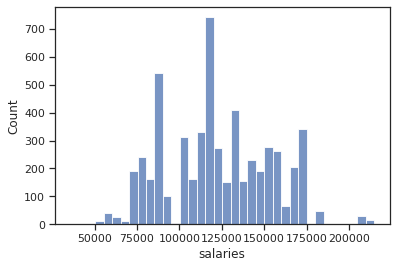

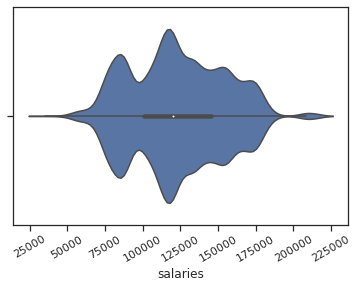

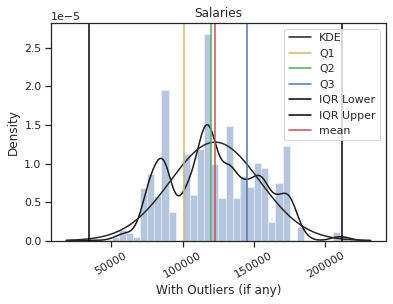

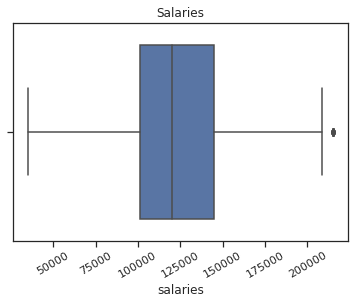

There are 16 records below and 0 above.
Records Including Outliers: 9703
Records Without Outliers: 5522


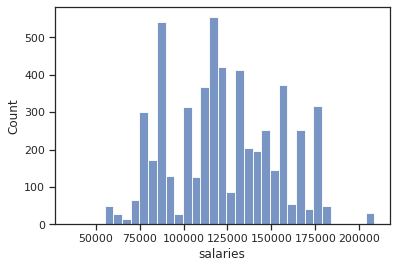

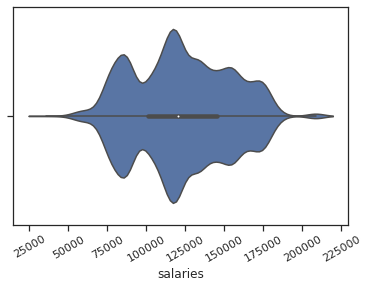

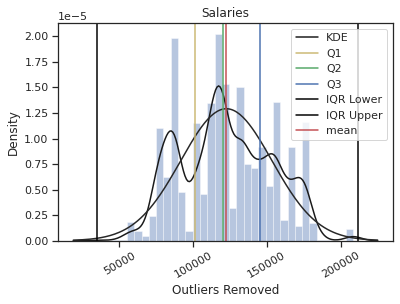

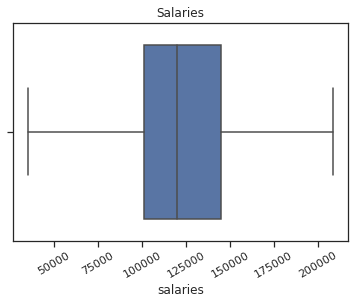

In [46]:


sal_data, q1, q3 = iqr_detect(data, feature='salaries')
no_sal = data[data.salaries.isnull()]
dataz = pd.concat([no_sal,sal_data])

In [47]:
print(featureReport(data, feature = 'salaries'),'\n')
dataz[['salary','estimated_salary', 'salaries']].head(5)

-- salaries report --
Missing 4165 out of 9703 Records
Percent Missing: 42.9%
Unique Values: 168
Min: 35360.0
Max: 215000.0
Mean: 122793.1679
Mode: 175000.0
Std.Dev: 31236.5906
None 



,salary,estimated_salary,salaries
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,Full-time,NaN,NaN
4,Full-time,NaN,NaN
5,NaN,NaN,NaN


In [48]:
null = sum(data.salaries.isnull())
nnull = sum(data.salaries.notnull())
print('')
print(f'The data contains {data.shape[0]} rows of individual job postings with values for {data.shape[1]} columns based on\n different sections of each post\'s web page.')
print('')
print(f'- Out of {len(data)} job postings {nnull} or {round(nnull/len(data)*100,2)}% include some sort of salary information,\n- The remaining {null} rowws, or {round(null/len(data)*100,2)}% are missing salary data.')
#\n- Also, there are no null values in the rest of the table meaning we won\'t need\n  to lose any data by dropping rows. While the null values in the Pay column will\n  simply be dropped after we translate the not nulls into the target.')


data[data['salaries'].notna()].salaries



The data contains 9703 rows of individual job postings with values for 22 columns based on
 different sections of each post's web page.

- Out of 9703 job postings 5538 or 57.08% include some sort of salary information,
- The remaining 4165 rowws, or 42.92% are missing salary data.


0         85000.0
8        150000.0
10        95000.0
14       116000.0
16       137000.0
           ...   
12713    105500.0
12714    107500.0
12716    121000.0
12717    137000.0
12719     94150.0
Name: salaries, Length: 5538, dtype: float64

57.08% of the data has salaries information, should be an easy target
- Dropping 48 outliers now leaves 5538, or 57.08%, of rows with with salaries information,
- The remaining 4165 rows, or 42.92%, are missing salaries data.


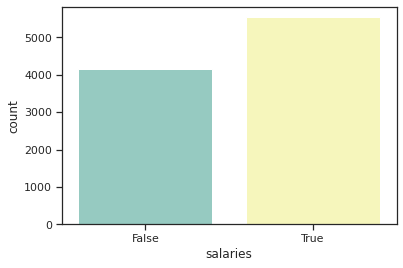

In [49]:

null = len(data[data.salaries.isnull()])
nnull = len(data[data.salaries.notnull()])
print(f'{round(nnull/len(data)*100,2)}% of the data has salaries information, should be an easy target')

sns.countplot(x='salaries', data=data.notnull(), palette='Set3')
print(f'- Dropping {len(outliers)} outliers now leaves {nnull}, or {round(nnull/len(data)*100,2)}%, of rows with with salaries information,\n- The remaining {null} rows, or {round(null/len(data)*100,2)}%, are missing salaries data.')


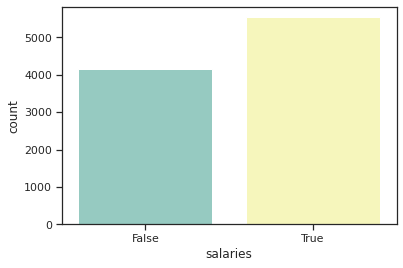

In [50]:
sns.countplot(x='salaries', data=data.notnull(), palette='Set3')
plt.show()

In [51]:
null = len(data[data.salary.isnull()])
nnull = len(data[data.salary.notnull()])
print(f'{round(nnull/len(data)*100,2)}% of the data has salary information, should be an easy target')

64.07% of the data has salary information, should be an easy target


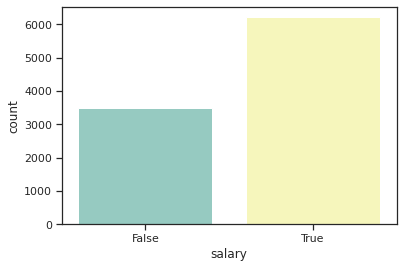

64.07% of the data has salary information, should be an easy target


In [52]:
sns.countplot(x='salary', data=data.notnull(), palette='Set3')
plt.show()


null = len(data[data.salary.isnull()])
nnull = len(data[data.salary.notnull()])
print(f'{round(nnull/len(data)*100,2)}% of the data has salary information, should be an easy target')


### 4.1 Target
Before I can begin splitting the data I need to set the target for my methodology of training four seperate logistic regression models. I'm doing this because I'd like my classifications to be as accurate as possible, and also, by building my NLP strategy around a particular label, i.e. finding common words for that label as opposed to being generalized through the entire corpus\

I'm going to one-hot-encode the target feature so I can select each of the next columns as my y - one for each model.



##
I need to make one model for each target. Before doing so, I'll need to use gridsearch to find the best hyperperamters.
Looping through each target, I set y to that specific single-column binary '(for target in targets target == 0 or 1)'
Then do a test train split before setting up the pipeline. The grid being use in this case is the selection of hyperperamters I want to check.


In [53]:
shape = data.shape
print(f"The {shape[0]} rows of data now have {shape[1]} variables whose values are now cleaned and typed properly.\nThe only missing values are in Salary which is my target.\nNext, I'll conduct analysis, encoding, and scaling of each feature, starting with Salary which .")
data.describe(include = 'all')

The 9703 rows of data now have 22 variables whose values are now cleaned and typed properly.
The only missing values are in Salary which is my target.
Next, I'll conduct analysis, encoding, and scaling of each feature, starting with Salary which .


,company,description,estimated_salary,extractdate,job_type_items,location,postdate,rating,requirements,salary,...,url,jobtype,dateposted,remote,state,city,text,cleanedsal,cleanedest,salaries
count,9703,9703,3799,9703,9703,9703,9703,9703.000000,603,6217,...,9703,9703,9703,9703,9703,9703,9703,1739.000000,3799.000000,5538.000000
unique,221,357,173,2,3,369,5,NaN,7,60,...,2208,3,3,2,1,192,438,NaN,NaN,NaN
top,parexel,[remote] data scientist location: united state...,"['', 'Not provided by employer', ""$137K - $174...",2022-07-26,none,remote in united states,postedtoday,NaN,us work authorization (required)bachelor's (pr...,Full-time,...,https://www.indeed.com/rc/clk?jk=9e6252824cab4...,,2022-07-26 00:00:00,Not Remote,,austin,us work authorization required bachelor s pref...,NaN,NaN,NaN
freq,536,268,130,7644,8311,268,5283,NaN,266,4311,...,130,8311,6772,6149,9703,661,262,NaN,NaN,NaN
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2022-07-25 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2022-07-27 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.767886,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130441.784934,119.291998,122793.167931
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.319731,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37644.882105,27.114504,31239.411224
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.800000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35360.000000,45.600000,35360.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.600000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88250.000000,102.150000,101000.000000


In [54]:
def Q(row):
    """
    Subtracts the distance (in days) provided by the postD function.
    Args:
        row (record in the data): record

    Returns:
        datetime object: extract date - relative age = actual post date
    """
    q1 = np.quantile(data[data.salaries.notna()].salaries, 0.25)
    q2 = np.quantile(data[data.salaries.notna()].salaries, 0.5)
    q3 = np.quantile(data[data.salaries.notna()].salaries, 0.75)


    
    salary = row['salaries']
    if salary != np.nan:
        if salary < q1:
            row['Q1'] = 1
            row['target'] = 1

        if (salary >= q1) & (salary < q2):
            row['Q2'] = 1
            row['target'] = 2


        if (salary >= q2) & (salary < q3):
            row['Q3'] = 1
            row['target'] = 3


        if salary >= q3:
            row['Q4'] = 1
            row['target'] = 4

        if row['target'] == 0:
            row['target'] = np.nan
    
    return row



data['Q1'] = 0
data['Q2'] = 0
data['Q3'] = 0
data['Q4'] = 0
data['target'] = 0



data = data.apply( lambda row : Q(row), axis = 1)
for i,j in sorted(data.target.value_counts().items()):
    print(i,j)

1.0 1334
2.0 1358
3.0 1408
4.0 1438


A new target variable has been created and its values are nan, 1, 2, 3, and 4 - representing the unknown set, and four labels for the taget.

## EDA

### 2.2 Univariate Feature Analysis & Centering
I'm going to employ visual and statistical methods to analyze each feature, starting with the target, and outside of scaling, prepare them for logistic regression which will require that each feature's vaues are normally distributes.


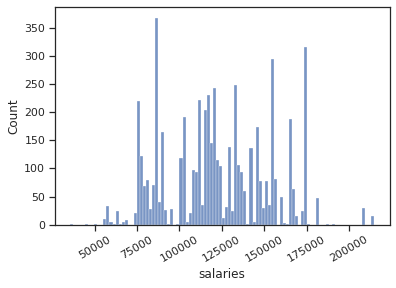

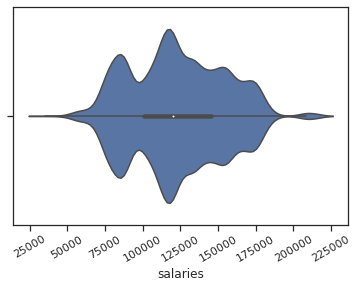

In [55]:


sns.histplot(data,x='salaries',bins=100)
plt.xticks(rotation=30)
plt.show()

sns.violinplot(x="salaries", data=data)
plt.xticks(rotation=30)
plt.show()



'dateposted'
This isn't going into the pipelie, despite some interesting patterns, I don't think there's enough periodic/seasonality information available here. Still, great for visualizing the job market.



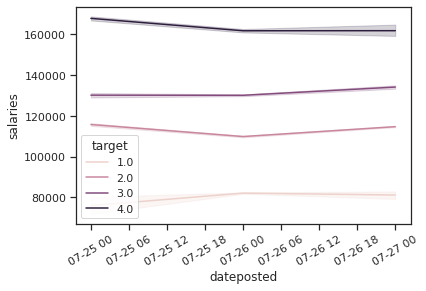

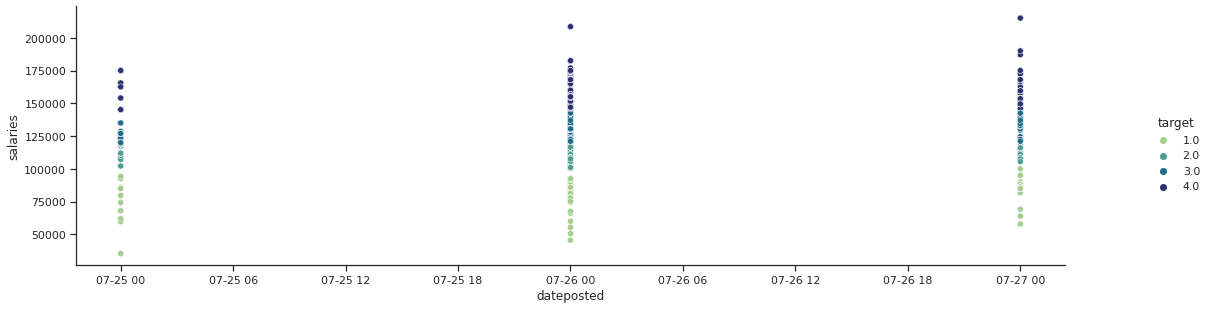

In [56]:
sns.lineplot(x="dateposted", y="salaries", hue="target", data=data)
plt.xticks(rotation=30)
plt.show()

ax = sns.pairplot(data=data,
                  x_vars=['dateposted'],
                  y_vars=['salaries'], height=8, hue="target", palette="crest")

ax.fig.set_size_inches(18,4)

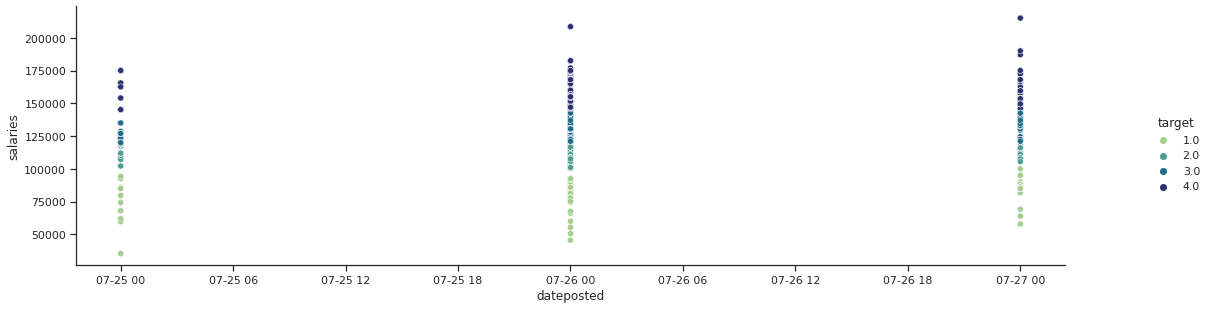

In [57]:
ax = sns.pairplot(data=data[data.salaries.notna()],
                  x_vars=['dateposted'],
                  y_vars=['salaries'], height=8, hue="target", palette="crest")

ax.fig.set_size_inches(18,4)

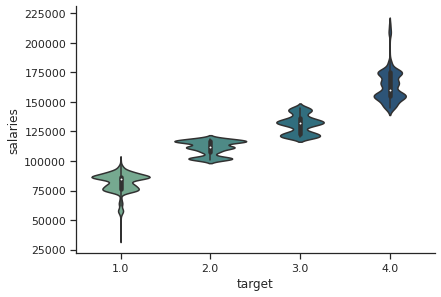

In [58]:
g = sns.catplot(x="target", y='salaries', kind="violin", data=data, height=4, aspect=1.5, palette="crest")
sns.swarmplot(x="target", y='salaries', color="k", size=.05, data=data, ax=g.ax)
plt.show()

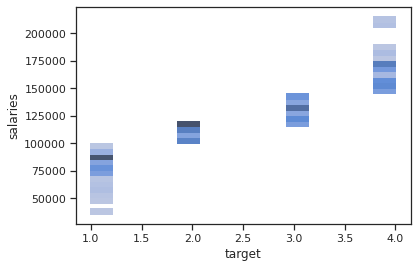

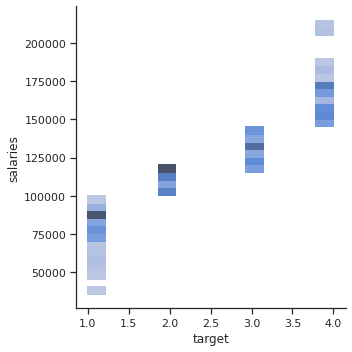

0    8369
1    1334
Name: Q1, dtype: int64 

0    8345
1    1358
Name: Q2, dtype: int64 

0    8295
1    1408
Name: Q3, dtype: int64 

0    8265
1    1438
Name: Q4, dtype: int64 

-- target report --
Missing 4165 out of 9703 Records
Percent Missing: 42.9%
Unique Values: 5
Min: 1.0
Max: 4.0
Mean: 2.5327
Mode: 4.0
Std.Dev: 1.118
None 



In [59]:
sns.histplot(data=data, x='target',y='salaries')
plt.show()

sns.displot(data=data, x='target',y='salaries')
plt.show()

for i in data[['Q1','Q2','Q3','Q4']]:
    print(data[i].value_counts(),'\n')

print(featureReport(data, feature = 'target'),'\n')

In [60]:
data.select_dtypes('number').columns

Index(['rating', 'cleanedsal', 'cleanedest', 'salaries', 'Q1', 'Q2', 'Q3',
       'Q4', 'target'],
      dtype='object')

In [61]:
"""data2 = data.dropna()
data2.dropna(inplace=True)

target = 'target'

associated = []

for i in ['rating','salaries']:
    if i == target:
        continue
    else:
        pearson_cor, pval = pearsonr(data2[i],data2[target])

    if pearson_cor > .3:
        associated.append([i,pearson_cor])

# Extracting column names of the dependent variables that passed the pearson correlation test of being at least .3
num_cols = []
for i in associated:
    num_cols.append(i[0])
num_cols"""



"data2 = data.dropna()\ndata2.dropna(inplace=True)\n\ntarget = 'target'\n\nassociated = []\n\nfor i in ['rating','salaries']:\n    if i == target:\n        continue\n    else:\n        pearson_cor, pval = pearsonr(data2[i],data2[target])\n\n    if pearson_cor > .3:\n        associated.append([i,pearson_cor])\n\n# Extracting column names of the dependent variables that passed the pearson correlation test of being at least .3\nnum_cols = []\nfor i in associated:\n    num_cols.append(i[0])\nnum_cols"

In [62]:
data


,company,description,estimated_salary,extractdate,job_type_items,location,postdate,rating,requirements,salary,...,city,text,cleanedsal,cleanedest,salaries,Q1,Q2,Q3,Q4,target
0,logic2020 inc.,company description we’re a six-time “best c...,NaN,2022-07-27,['full-time'],"huntsville, al",postedjust posted,3.6,NaN,"From $85,000 a year - Full-time",...,huntsville,along the way you ll collaborate daily with a ...,85000.0,NaN,85000.0,1,0,0,0,1.0
1,wells fargo bank,about this role: wells fargo is seeking a sen...,NaN,2022-07-27,none,"tempe, az",postedjust posted,3.7,NaN,NaN,...,tempe,they are accountable for execution of all appl...,NaN,NaN,NaN,0,0,0,0,NaN
2,cvs health,build data-centric platforms for advanced anal...,NaN,2022-07-27,none,arizona,postedtoday,3.2,NaN,NaN,...,,build data centric platforms for advanced anal...,NaN,NaN,NaN,0,0,0,0,NaN
3,amazon web services inc.,"bachelors degree in computer science, engineer...",NaN,2022-07-27,none,arizona,postedtoday,3.4,NaN,Full-time,...,,bachelors degree in computer science engineeri...,NaN,NaN,NaN,0,0,0,0,NaN
4,adelante healthcare,senior financial data analyst3033 n central av...,NaN,2022-07-27,none,"phoenix, az 85012 (encanto area)",postedtoday,4.0,NaN,Full-time,...,phoenix,ability to research analyze and present financ...,NaN,NaN,NaN,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12713,shine technologies llc,description: position overview: we are look...,"['', 'Not provided by employer', ""$93K - $118K...",2022-07-26,none,"fitchburg, wi 53575",postedjust posted,3.3,NaN,Full-time,...,fitchburg,ms ph d degree in relevant engineering program...,NaN,105.50,105500.0,0,1,0,0,2.0
12714,parexel,"parexel is looking for a senior manager, stati...","['', 'Not provided by employer', ""$95K - $120K...",2022-07-26,none,"remote in madison, wi 53706",postedjust posted,3.6,NaN,NaN,...,madison,the senior manager may also be part of a proje...,NaN,107.50,107500.0,0,1,0,0,2.0
12716,parexel,be part of our empowered parexel statistical p...,"['', 'Not provided by employer', ""$107K - $135...",2022-07-26,none,"remote in madison, wi 53706",postedjust posted,3.6,NaN,NaN,...,madison,provide leadership project specific training s...,NaN,121.00,121000.0,0,0,1,0,3.0
12717,parexel,be part of our empowered parexel statistical p...,"['', 'Not provided by employer', ""$121K - $153...",2022-07-26,none,"remote in madison, wi 53706",postedjust posted,3.6,NaN,NaN,...,madison,provide leadership project specific training s...,NaN,137.00,137000.0,0,0,1,0,3.0


In [64]:
#TODO complete this by collecting the most significant colinear features and possibl removing them.
"""
score_dictionary = {}
for i in data.select_dtypes('object').columns:
    feature = pd.crosstab(data[i], data[target])
    # calculate the chi squared statistic and save it as chi2, then print it:
    chi2, pval, dof, expected = chi2_contingency(feature)
    score_dictionary[i] = round(chi2,2)
score_df = pd.DataFrame(score_dictionary.items(), columns=['feature','chi2 score']).sort_values('chi2 score', ascending=False)
score_df[:-1]"""

"\nscore_dictionary = {}\nfor i in data.select_dtypes('object').columns:\n    feature = pd.crosstab(data[i], data[target])\n    # calculate the chi squared statistic and save it as chi2, then print it:\n    chi2, pval, dof, expected = chi2_contingency(feature)\n    score_dictionary[i] = round(chi2,2)\nscore_df = pd.DataFrame(score_dictionary.items(), columns=['feature','chi2 score']).sort_values('chi2 score', ascending=False)\nscore_df[:-1]"

In [65]:
data = data[['company','job_title','state','city','rating','text', 'salaries', 'target', 'Q1', 'Q2', 'Q3', 'Q4']]

In [66]:
data

,company,job_title,state,city,rating,text,salaries,target,Q1,Q2,Q3,Q4
0,logic2020 inc.,data scientist,,huntsville,3.6,along the way you ll collaborate daily with a ...,85000.0,1.0,1,0,0,0
1,wells fargo bank,lead enterprise risk officer strategic risk ar...,,tempe,3.7,they are accountable for execution of all appl...,NaN,NaN,0,0,0,0
2,cvs health,senior data scientist,,,3.2,build data centric platforms for advanced anal...,NaN,NaN,0,0,0,0
3,amazon web services inc.,machine learning engineer,,,3.4,bachelors degree in computer science engineeri...,NaN,NaN,0,0,0,0
4,adelante healthcare,senior financial data analyst,,phoenix,4.0,ability to research analyze and present financ...,NaN,NaN,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
12713,shine technologies llc,data scientist,,fitchburg,3.3,ms ph d degree in relevant engineering program...,105500.0,2.0,0,1,0,0
12714,parexel,senior manager statistical programming,,madison,3.6,the senior manager may also be part of a proje...,107500.0,2.0,0,1,0,0
12716,parexel,senior statistical programmer,,madison,3.6,provide leadership project specific training s...,121000.0,3.0,0,0,1,0
12717,parexel,principal statistical programmer,,madison,3.6,provide leadership project specific training s...,137000.0,3.0,0,0,1,0


In [67]:
# check for missing
print(data.isna().sum().sort_values(ascending=False))

salaries     4165
target       4165
company         0
job_title       0
state           0
city            0
rating          0
text            0
Q1              0
Q2              0
Q3              0
Q4              0
dtype: int64


In [68]:
"""
# check for duplcates.
print(f'Number of dupes: {sum(data.duplicated())}')
data.drop_duplicates(inplace=True)
# check for missing
print(data.isna().sum().sort_values(ascending=False))
data.dropna(inplace = True)

print(f'Number of dupes: {sum(data.duplicated())}')
print(data.isna().sum().sort_values(ascending=False))

"""

"\n# check for duplcates.\nprint(f'Number of dupes: {sum(data.duplicated())}')\ndata.drop_duplicates(inplace=True)\n# check for missing\nprint(data.isna().sum().sort_values(ascending=False))\ndata.dropna(inplace = True)\n\nprint(f'Number of dupes: {sum(data.duplicated())}')\nprint(data.isna().sum().sort_values(ascending=False))\n\n"

## Pipelining

I need to make one model for each target. Before doing so, I'll need to use gridsearch to find the best hyperperamters.
Looping through each target, I set y to that specific single-column binary '(for target in targets target == 0 or 1)'
Then do a test train split before setting up the pipeline. The grid being use in this case is the selection of hyperperamters I want to check.

In [69]:

def grid_search_pipe():
    targets = ['Q1','Q2','Q3','Q4']
    X = data.drop(targets, axis=1)

    le_cols = ['company', 'job_title', 'state', 'city']
    scal_cols = ['rating']

    evaluations = {}

    
    for i in targets:
    # test/train split
        y = data[i]
        x_train, x_test, y_train, y_test = train_test_split(X, y , test_size=.2, random_state=42)


        preprocessor = ColumnTransformer(
            transformers=[
                ('text', TfidfVectorizer(ngram_range=(1,3), analyzer = 'word',max_features=1000,stop_words='english',decode_error='ignore'), 'text'),
                ('category', OneHotEncoder(handle_unknown ='ignore'), le_cols),
                ('scaler', StandardScaler(), scal_cols)
                
                ],remainder='drop')
        #   populating parameter grid to search
        grid = [
            {
            'classifier' : [LogisticRegression()],
            #'classifier__penalty' : ['l1', 'l2'],
            #'classifier__C' : np.logspace(-4, 4, 20),
            'classifier__solver' : ['liblinear']}
            ]

        pipe = Pipeline(
            steps=[
            ('preprocessor', preprocessor),
            ('classifier', LogisticRegression(grid)),
            ],
            )


        
        grid_search = GridSearchCV(pipe, param_grid=grid, verbose=2, return_train_score=True)
        grid_search.fit(x_train,y_train)

        print("Best parameter (CV score=%0.3f):" % grid_search.best_score_)
        print(grid_search.best_params_)


        if i not in evaluations.keys():
            evaluations[i] = {
                'grid_search':grid_search,
                'x_train':x_train,
                'y_train':y_train,
                'x_test':x_test,
                'y_test':y_test
                
            }


    return evaluations


evaluations = grid_search_pipe()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END classifier=LogisticRegression(), classifier__solver=liblinear; total time=   8.6s
[CV] END classifier=LogisticRegression(), classifier__solver=liblinear; total time=   8.1s
[CV] END classifier=LogisticRegression(), classifier__solver=liblinear; total time=   7.7s
[CV] END classifier=LogisticRegression(), classifier__solver=liblinear; total time=   7.5s
[CV] END classifier=LogisticRegression(), classifier__solver=liblinear; total time=   7.4s
Best parameter (CV score=0.995):
{'classifier': LogisticRegression(solver='liblinear'), 'classifier__solver': 'liblinear'}
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END classifier=LogisticRegression(), classifier__solver=liblinear; total time=  10.4s
[CV] END classifier=LogisticRegression(), classifier__solver=liblinear; total time=   7.3s
[CV] END classifier=LogisticRegression(), classifier__solver=liblinear; total time=   7.2s
[CV] END classifier=LogisticReg

In [ ]:
#TODO Show the best hyperparameters for each class

## Modelling

In [70]:
def make_model(evaluations):
    targets = ['Q1','Q2','Q3','Q4']
    X = data.drop(targets, axis=1)

    test_results = {}

    for i in targets:
        evaluation = evaluations[i]['grid_search']
        params = evaluation.best_params_


        y = data[i]
        x_train, x_test, y_train, y_test = train_test_split(X, y , test_size=.2, random_state=42)



        le_cols = ['company', 'job_title', 'state', 'city']
        scal_cols = ['rating']

        preprocessor = ColumnTransformer(
            transformers=[
                ('text', TfidfVectorizer(ngram_range=(1,3), analyzer = 'word',max_features=1000,stop_words='english',decode_error='ignore'), 'text'),
                ('category', OneHotEncoder(handle_unknown ='ignore'), le_cols),
                ('scaler', MinMaxScaler(), scal_cols)
                
                ],remainder='drop')


        pipe = Pipeline(
            steps=[
                ('preprocessor', preprocessor),
                ('classifier', params['classifier']),
            ],
        )


        pipe.fit(x_train,y_train)

        
        y_prob = pipe.predict_proba(x_test)
        predict_y = pipe.predict(x_test)

        score = pipe.score(x_train, y_train)


        ### check
        check = pd.DataFrame(preprocessor.fit_transform(x_train,y_train).toarray())


        if i not in test_results.keys():
            test_results[i] = [pipe, x_train, y_train, x_test, y_test, predict_y, y_prob, score]
                
    return test_results, check
        
test_results, check = make_model(evaluations)


In [71]:
test_results['Q1'][0]

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  TfidfVectorizer(decode_error='ignore',
                                                                  max_features=1000,
                                                                  ngram_range=(1,
                                                                               3),
                                                                  stop_words='english'),
                                                  'text'),
                                                 ('category',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['company', 'job_title',
                                                   'state', 'city']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['rating'])])),
                ('classifier', LogisticRegression(solver='liblinear'))])

In [72]:
def combinator(test_results):
    targets = ['Q1','Q2','Q3','Q4']

    resultsDB = {}
    lst = []

    
    for label in targets:
        data_dict = {}
        pipe = test_results[label][0]
        x_test = test_results[label][3]
        y_test = test_results[label][4]
        y_prob = pipe.predict_proba(x_test)
        y_pred = pipe.predict(x_test)



        data_dict = {
            f'{label}_y_test':y_test, 
             f'{label}_pred': y_pred.tolist(),
             f'{label}_probabilities': y_prob.tolist()
             }


        out = pd.DataFrame(data_dict)
        lst.append(out)

    results_table = x_test
    for i, label in zip(lst, targets):
        results_table = results_table.join(i, lsuffix=label)
    #results_table = results_table.join(lst[1], lsuffix='__')
    #for label, results in zip(targets,lst):
    #    results_table = results_table.join(results, lsuffix=label)

    def Q(row):
        """Subtracts the distance (in days) provided by the postD function.
        Args:
            row (record in the data): record

        Returns:
            datetime object: extract date - relative age = actual post date
        """
        #np.argmax(row[['Q1_Prob', 'Q2_Prob','Q3_Prob','Q4_Prob']].values)
        Q1 = row['Q1_probabilities'][1]
        Q2 = row['Q2_probabilities'][1]
        Q3 = row['Q3_probabilities'][1]
        Q4 = row['Q4_probabilities'][1]
        lst = [Q1,Q2,Q3,Q4]
        # adding 1 so these correspond to the target names rather than 0 indexed.
        return int(lst.index(max(lst))+1)
        #next, check if that 


    results_table['Q'] = results_table.apply( lambda row : Q(row), axis = 1)


    return results_table
   

results_table = combinator(test_results)
results_table.head()

,company,job_title,state,city,rating,text,salaries,target,Q1_y_test,Q1_pred,...,Q2_y_test,Q2_pred,Q2_probabilities,Q3_y_test,Q3_pred,Q3_probabilities,Q4_y_test,Q4_pred,Q4_probabilities,Q
561,the travelers companies inc.,manager sr. data scientist remote,,hartford,3.7,the individual in this role is expected to be ...,NaN,NaN,0,0,...,0,0,"[0.9928873711506553, 0.00711262884934472]",0,0,"[0.9823390872070411, 0.017660912792958876]",0,0,"[0.9970831274067646, 0.0029168725932353194]",3
10072,twiceasnice recruiting,remote data scientist predictive maintenance e...,,,4.4,us work authorization required bachelor s pref...,175000.0,4.0,0,0,...,0,0,"[0.9962265355144112, 0.0037734644855888367]",0,0,"[0.9956682497634157, 0.0043317502365843134]",1,1,"[0.02305252188402729, 0.9769474781159727]",4
9863,u.s. bank,data scientist customer experience remote,,,3.6,ability to data mine analyze data and present ...,80382.5,1.0,1,1,...,0,0,"[0.9905273419500201, 0.00947265804997993]",0,0,"[0.9895415765594242, 0.010458423440575747]",0,0,"[0.992794336076785, 0.007205663923215025]",1
1954,cvs health,executive director data science chief scientif...,,,3.2,outstanding skills in developing analytics and...,NaN,NaN,0,0,...,0,0,"[0.9950392608036123, 0.0049607391963877295]",0,0,"[0.9942346804106517, 0.005765319589348321]",0,0,"[0.9967725671659634, 0.0032274328340365995]",1
8051,twiceasnice recruiting,remote data scientist predictive maintenance e...,,,4.4,us work authorization required bachelor s pref...,175000.0,4.0,0,0,...,0,0,"[0.9962265355144112, 0.0037734644855888367]",0,0,"[0.9956682497634157, 0.0043317502365843134]",1,1,"[0.02305252188402729, 0.9769474781159727]",4


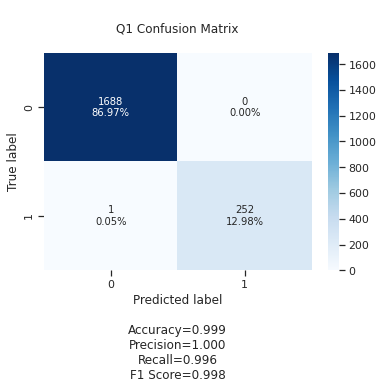

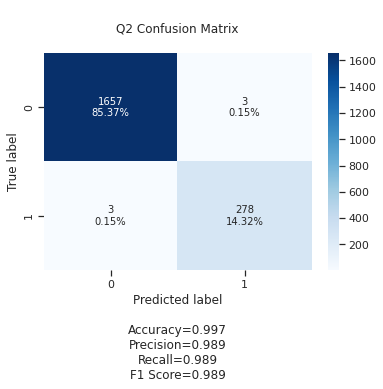

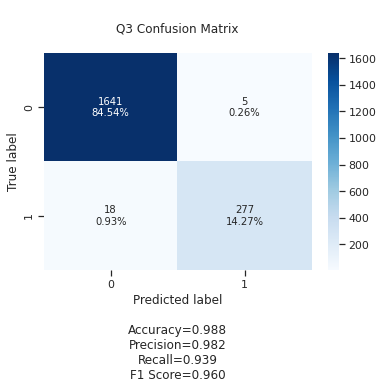

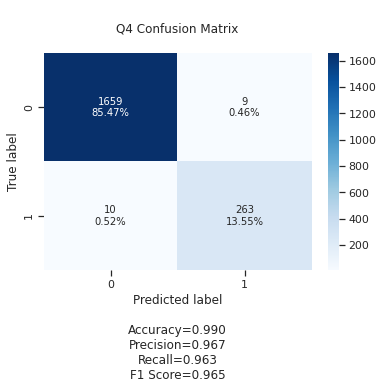

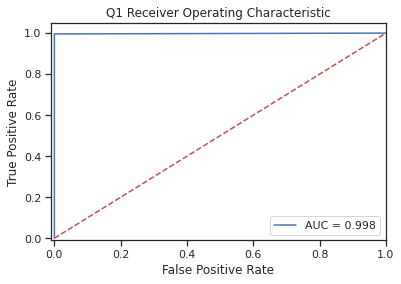

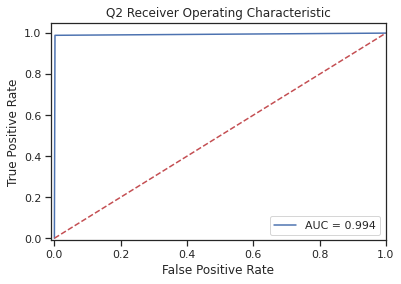

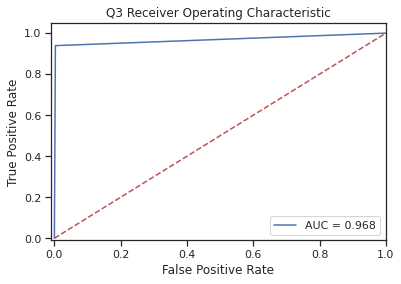

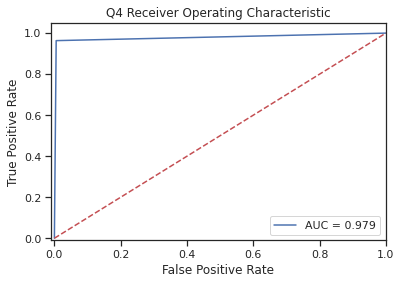

In [178]:
def evaluations():
    labels = ['Q1','Q2','Q3','Q4']
    metrics_dict = {}
    class_reports = []
    te_confusions = []
    for label in labels:
        pipe = test_results[label][0]
        x_train = test_results[label][1]
        y_train = test_results[label][2]

        x_test = test_results[label][3]
        y_test = test_results[label][4]

        y_pred =  test_results[label][5]
        y_prob =  test_results[label][6]

        

        # classification report
        class_reports.append(classification_report(y_test, y_pred))

        # confusion matrix
        te_confusions.append(confusion_matrix(y_test, y_pred))


        # ROC
        roc_metrics = []
        fpr, tpr, threshold = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr, tpr)
        roc_metrics.append([fpr,tpr,roc_auc])




        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        model_score = test_results[label][7]
        hamming_loss_ = hamming_loss(y_test,y_pred)


        if label not in metrics_dict.keys():
            metrics_dict[label] = {'precision':precision, 'recall':recall,'f1':f1, 'model_score':model_score,'tpr':tpr,'fpr':fpr,'roc_auc':roc_auc, 'hamming_loss':hamming_loss_, 'accuracy':accuracy}


    for label, cf in zip(labels, te_confusions):
        make_confusion_matrix(cf, title='\n'+label+' Confusion Matrix\n')
        plt.show()
        
    for label in labels:
        fpr = metrics_dict[label]['fpr']
        tpr = metrics_dict[label]['tpr']
        roc_auc = metrics_dict[label]['roc_auc']
        plt.title(f'{label} Receiver Operating Characteristic')
        plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([-.01, 1.])
        plt.ylim([-.01, 1.05])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        img = plt.show()
        plt.show()


    metrics_DB = pd.DataFrame(metrics_dict).T
    


    return metrics_DB, class_reports


metrics_DB, class_reports = evaluations()



Accuracy:
The accuracy returns the proportion of correct predictions.
Accuracy = (TP + TN)/(TP + TN + FP + FN)

Precision:
The precision returns the proportion of true positives among all the values predicted as positive.
Precision = TP/(TP + FP) = 40/(40 + 1) = 0.98 = 98%

Recall:
The recall returns the proportion of positive values correctly predicted.
Recall = TP/(TP + FN) = 40/(40 + 7) = 0.85 = 85%

Specificity:
The specificity returns the proportion of negative values correctly predicted.
Specificity: TN/ (TN + FP) = 66/(66 + 1) = 0.99 = 99%

F1-score:
The f1-score is the harmonic mean of precision and recall. It is often used to compare classifiers.
F1-score = (2 x Precision x Recall)/(Precision + Recall) = 0.91 = 91%



In [182]:
metrics_DB

,precision,recall,f1,model_score,tpr,fpr,roc_auc,hamming_loss,accuracy
Q1,1.0,0.996047,0.99802,0.998841,"[0.0, 0.9960474308300395, 1.0]","[0.0, 0.0, 1.0]",0.998024,0.000515,0.999485
Q2,0.989324,0.989324,0.989324,0.997681,"[0.0, 0.9893238434163701, 1.0]","[0.0, 0.0018072289156626507, 1.0]",0.993758,0.003091,0.996909
Q3,0.98227,0.938983,0.960139,0.993945,"[0.0, 0.9389830508474576, 1.0]","[0.0, 0.003037667071688943, 1.0]",0.967973,0.01185,0.98815
Q4,0.966912,0.96337,0.965138,0.994589,"[0.0, 0.9633699633699634, 1.0]","[0.0, 0.00539568345323741, 1.0]",0.978987,0.009789,0.990211


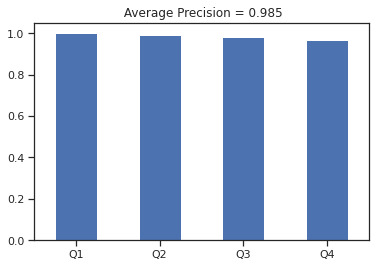

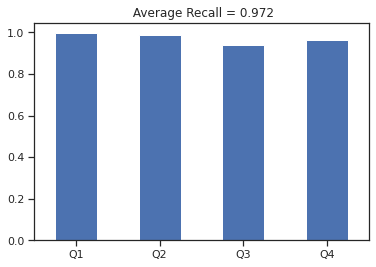

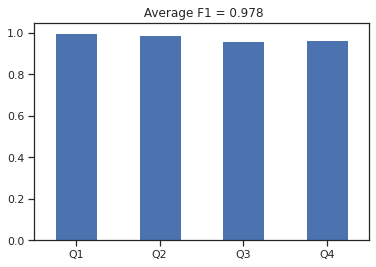

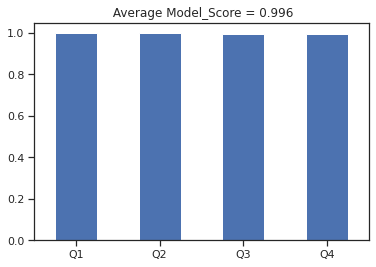

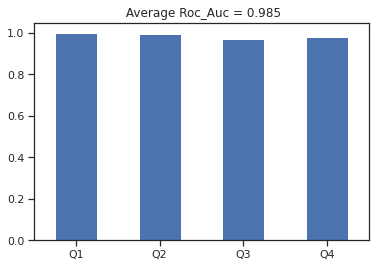

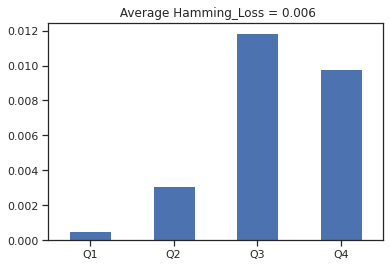

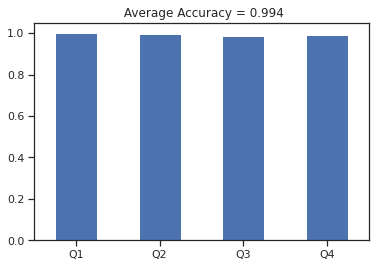

In [183]:
for i in metrics_DB.columns:
    if i not in ['tpr', 'fpr']:
        metrics_DB[i].plot(kind='bar')
        plt.title(f' Average {i.title()} = {round(np.mean(metrics_DB[i]),3)}')
        plt.xticks(rotation=0)
        plt.show()

In [184]:
for i in class_reports:
    print(i)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1688
           1       1.00      1.00      1.00       253

    accuracy                           1.00      1941
   macro avg       1.00      1.00      1.00      1941
weighted avg       1.00      1.00      1.00      1941

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1660
           1       0.99      0.99      0.99       281

    accuracy                           1.00      1941
   macro avg       0.99      0.99      0.99      1941
weighted avg       1.00      1.00      1.00      1941

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1646
           1       0.98      0.94      0.96       295

    accuracy                           0.99      1941
   macro avg       0.99      0.97      0.98      1941
weighted avg       0.99      0.99      0.99      1941

              preci

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1102 entries, 10072 to 7689
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   company           1102 non-null   object 
 1   job_title         1102 non-null   object 
 2   state             1102 non-null   object 
 3   city              1102 non-null   object 
 4   rating            1102 non-null   float64
 5   text              1102 non-null   object 
 6   salaries          1102 non-null   float64
 7   target            1102 non-null   float64
 8   Q1_y_test         1102 non-null   int64  
 9   Q1_pred           1102 non-null   int64  
 10  Q1_probabilities  1102 non-null   object 
 11  Q2_y_test         1102 non-null   int64  
 12  Q2_pred           1102 non-null   int64  
 13  Q2_probabilities  1102 non-null   object 
 14  Q3_y_test         1102 non-null   int64  
 15  Q3_pred           1102 non-null   int64  
 16  Q3_probabilities  1102 non-null   obje

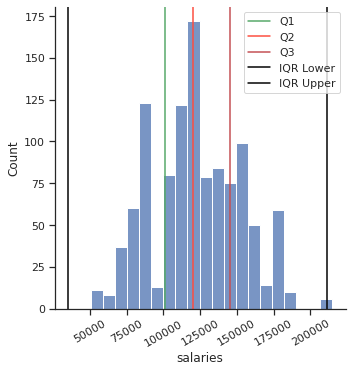

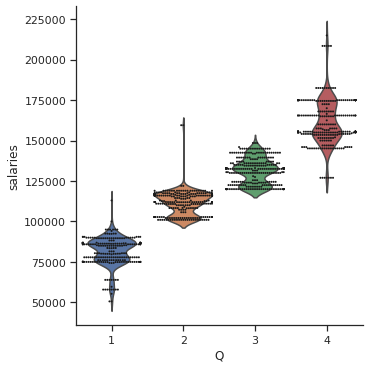

In [181]:

ohe = OneHotEncoder(sparse=False)
#results_table = results_table.join(pd.DataFrame(ohe.fit_transform(results_table[['Q']]), columns=['Q1','Q2','Q3','Q4']))

ohe = ohe.fit_transform(results_table[['Q']]).T

results_table['Q1'] = ohe[0]
results_table['Q2'] = ohe[1]
results_table['Q3'] = ohe[2]
results_table['Q4'] = ohe[3]

results_table
results_table.columns
results_table.to_csv(f'../app/data/tableau_table.csv', index=False)
results_table=results_table[results_table.salaries.notna()]
results_table[results_table.Q != results_table.target]

results_table.info()


q1 = np.quantile(results_table.salaries, 0.25)
q2 = np.quantile(results_table.salaries, 0.5)
q3 = np.quantile(results_table.salaries, 0.75)

# calc iqr
iqr = (q3 - q1)
# expand iqr to discern outliers
iqr_x = iqr*1.5

# setting the lower and upper limits
iqr_lower = q1-iqr_x
iqr_upper = q3+iqr_x


sns.displot(results_table.salaries)
plt.axvline(x=q1, label="Q1", c = 'g')
plt.axvline(x=q2, label="Q2", c = '#fd4d3f')
plt.axvline(x=q3, label="Q3", c = 'r')

plt.axvline(x=iqr_lower, label = 'IQR Lower', c = 'black')
plt.axvline(x=iqr_upper, label = 'IQR Upper', c = 'black')
plt.xticks(rotation=30)
plt.legend()
plt.show()

results_table.Q.value_counts()

g = sns.catplot(x="Q", y="salaries", kind="violin", inner=None, data=results_table)
sns.swarmplot(x="Q", y="salaries", color="k", size=2, data=results_table, ax=g.ax)

plt.xticks(rotation=0)

plt.show()

## NLP Stuff

In [ ]:

X_tfidf = tfidf.fit_transform(_test).toarray()
vocab = q1_vectorizer.vocabulary_
reverse_vocab = {v:k for k,v in vocab.items()}

feature_names = tfidf.get_feature_names()
df_tfidf = pd.DataFrame(X_tfidf, columns = feature_names)

idx = X_tfidf.argsort(axis=1)

tfidf_max10 = idx[:,-10:]

df_tfidf['top10'] = [[reverse_vocab.get(item) for item in row] for row in tfidf_max10 ]

df_tfidf['top10']
